<a href="https://colab.research.google.com/github/marekpiotradamczyk/ml_uwr_23/blob/main/10-notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning @ UWr 2023

**Lecture 10**

# Neural Networks

We know already how to solve such a problem and we know that we can use Logistic Regression in such cases:

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

n = 100
# Generating 50 data points from each Gaussian distribution
np.random.seed(0) # For reproducibility
data_red = np.random.multivariate_normal(mean=[-1, -1], cov=[[1, 0], [0, 1]], size=n)
data_blue = np.random.multivariate_normal(mean=[1, 1], cov=[[1, 0], [0, 1]], size=n)


# Combining data and creating labels
X = np.vstack((data_red, data_blue))
y = np.array([0]*n + [1]*n)  # 0 for first distribution, 1 for the second

# Logistic Regression
model = LogisticRegression()
model.fit(X, y)



LogisticRegression()

In [71]:
def plot_things(data_red, data_blue, lines, range_lim=5, caption=None):
    
    # Plotting the data points
    plt.scatter(data_red[:, 0], data_red[:, 1], color='red')
    plt.scatter(data_blue[:, 0], data_blue[:, 1], color='blue')
    
    xmin, xmax = -range_lim, range_lim
    ymin, ymax = -range_lim, range_lim
    for line in lines:
        w1, w2, b = line
        # Plotting the decision boundary
        # b = model.intercept_[0]
        # w1, w2 = model.coef_.T
        c = -b/w2
        m = -w1/w2
        xd = np.array([xmin, xmax])
        yd = m*xd + c
        plt.plot(xd, yd, 'k', lw=1, ls='--')
        
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('classification with 2D Gaussian Data' if caption is None else caption)
    plt.show()


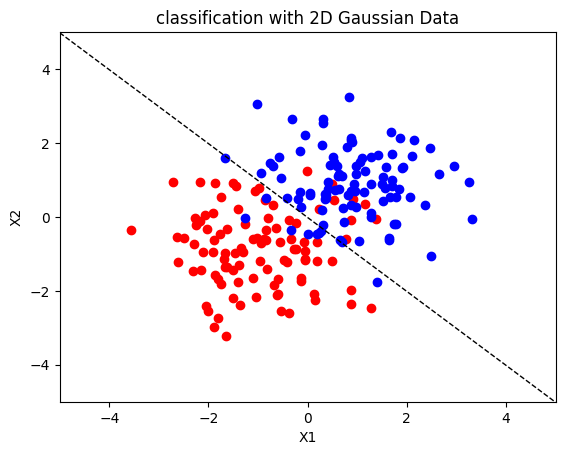

In [72]:
plot_things(data_red, data_blue, lines=[(model.coef_.T[0], model.coef_.T[0], model.intercept_[0])])

## automatic differentiation

Please analyze the code below in which the Logistic Regression algorithm is done from scratch, but with the use of automatic differentiation framework. Jax in this case

In [73]:
import jax
import jax.numpy as jnp
from jax import grad, random

# Define the logistic regression model
def logistic_regression(params, x):
    w, b = params
    return 1.0 / (1.0 + jnp.exp(-(jnp.dot(x, w) + b)))

# Define the binary cross-entropy loss function
def binary_cross_entropy(params, x, y):
    predictions = logistic_regression(params, x)
    loss = -jnp.mean(y * jnp.log(predictions) + (1 - y) * jnp.log(1 - predictions))
    return loss

# Initialize parameters randomly
key = random.PRNGKey(0)
w_init = random.normal(key, (2,))
b_init = random.normal(key, ())

# Convert data to JAX arrays
X_jax = jnp.array(X)
y_jax = jnp.array(y)


# Concatenate weights and bias into a single parameter vector
params = (w_init, b_init)


In [74]:

# Training loop
num_epochs = 1000
learning_rate = 0.01


for epoch in range(num_epochs):
    gradients = grad(binary_cross_entropy)(params, X_jax, y_jax)
    params = [param - learning_rate * gradient for param, gradient in zip(params, gradients)]

# Extract trained weights and bias
w_trained, b_trained = params


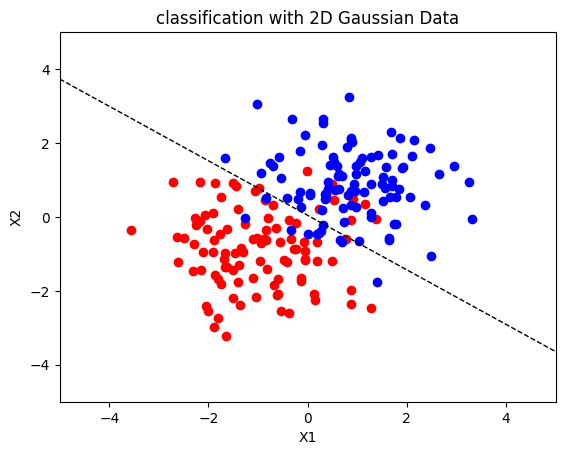

In [75]:
plot_things(data_red, data_blue, lines=[(w_trained[0], w_trained[1], b_trained)])

## automatic differentiation for non-linearly separable datasets

Logistic regression cannot solve the classification problem below, because for obvious reasons no single line can separate blue vs red.

In [76]:
# Generating data points for the updated request
data_blue1 = np.random.multivariate_normal(mean=[-3, -3], cov=[[1, 0], [0, 1]], size=n)
data_blue2 = np.random.multivariate_normal(mean=[3, 3], cov=[[1, 0], [0, 1]], size=n)
data_red1 = np.random.multivariate_normal(mean=[3, -3], cov=[[1, 0], [0, 1]], size=n)
data_red2 = np.random.multivariate_normal(mean=[-3, 3], cov=[[1, 0], [0, 1]], size=n)

data_blue = np.vstack((data_blue1, data_blue2))
data_red = np.vstack((data_red1, data_red2))



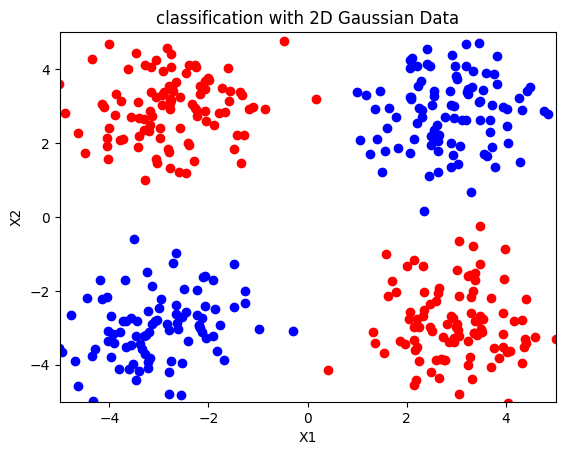

In [77]:
plot_things(data_red, data_blue, lines=[])

Let's just see that indeed Logistic Regression will fail:

In [78]:
# Combining the data for logistic regression
X = np.vstack((data_blue, data_red))
y = np.array([0]*len(data_blue) + [1]*len(data_red))  # 0 for blue class, 1 for red class

# Logistic Regression
model = LogisticRegression()
model.fit(X, y)


LogisticRegression()

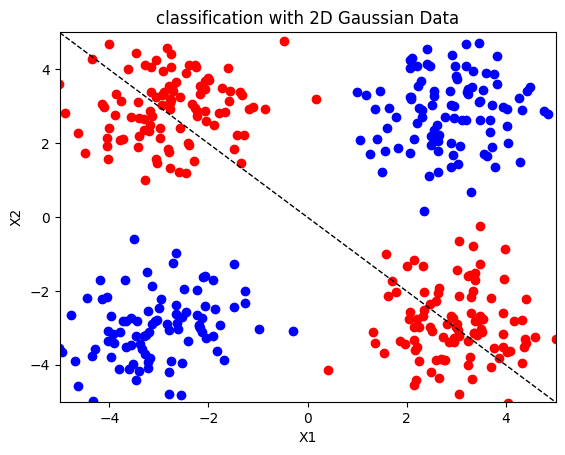

In [79]:
plot_things(data_red, data_blue, lines=[(model.coef_.T[0], model.coef_.T[0], model.intercept_[0])])

Yep, doesn't work.

However below we have a model which finds two lines (as in Logistic Regression), but these 2 lines are used later for yet another Logistic Regression classification.

In [80]:
import jax
import jax.numpy as jnp
from jax import grad, random

def sigmoid(z):
    return 1.0/(1.0 + jnp.exp(-z))

# Define the logistic regression model
def neural_network(params, x):
    wh1, bh1, wh2, bh2, wo, bo = params
    h1 = sigmoid(jnp.dot(x, wh1) + bh1)
    h2 = sigmoid(jnp.dot(x, wh2) + bh2)
    
    z = wo[0]*h1 + wo[1]*h2 + bo
       
    return sigmoid(z)

def hidden_layer(params, x):
    wh1, bh1, wh2, bh2, wo, bo = params
    h1 = sigmoid(jnp.dot(x, wh1) + bh1)
    h2 = sigmoid(jnp.dot(x, wh2) + bh2)
    return np.hstack([h1.reshape(-1,1),h2.reshape(-1,1)])

# Define the binary cross-entropy loss function
def binary_cross_entropy(params, x, y):
    predictions = neural_network(params, x)
    loss = -jnp.mean(y * jnp.log(predictions) + (1 - y) * jnp.log(1 - predictions))
    return loss

def predict(params, x):
    probs = neural_network(params, x)
    return probs.round()

# Initialize parameters randomly
key = random.PRNGKey(0)
wh1_init = random.normal(key, (2,))
bh1_init = random.normal(key, ())

wh2_init = random.normal(key, (2,))
bh2_init = random.normal(key, ())

wo_init = random.normal(key, (2,))
bo_init = random.normal(key, ())

# Convert data to JAX arrays
X_jax = jnp.array(X)
y_jax = jnp.array(y)

# Concatenate weights and bias into a single parameter vector
params = (wh1_init, bh1_init, wh2_init, bh2_init, wo_init, bo_init)



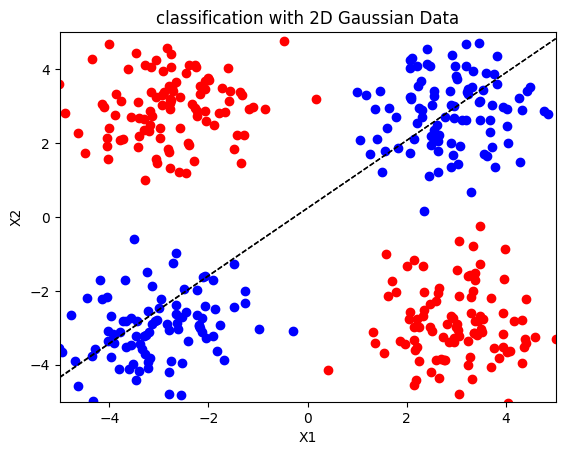

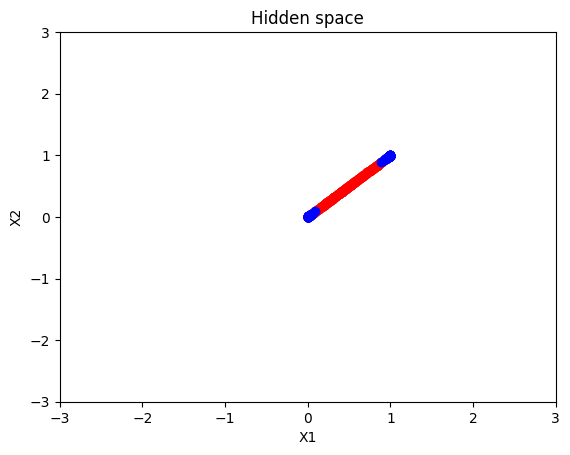

____________________________________________________________________________________________________


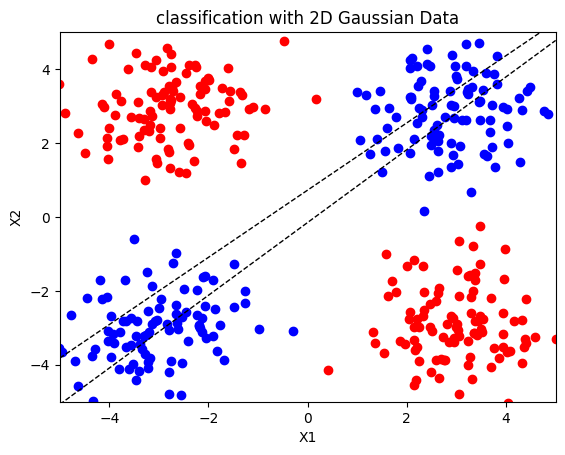

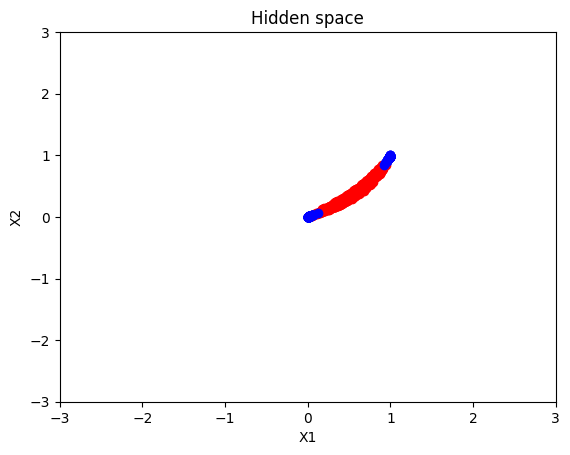

____________________________________________________________________________________________________


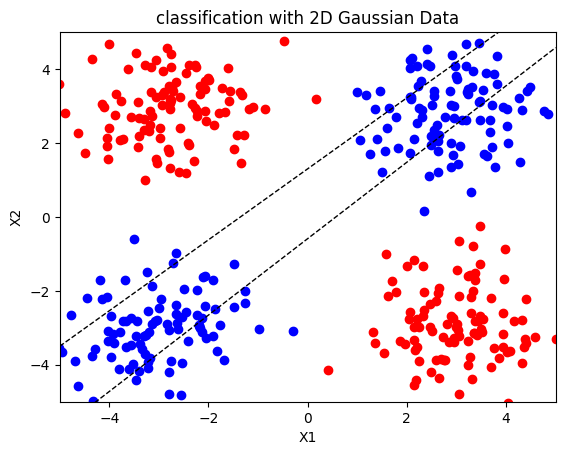

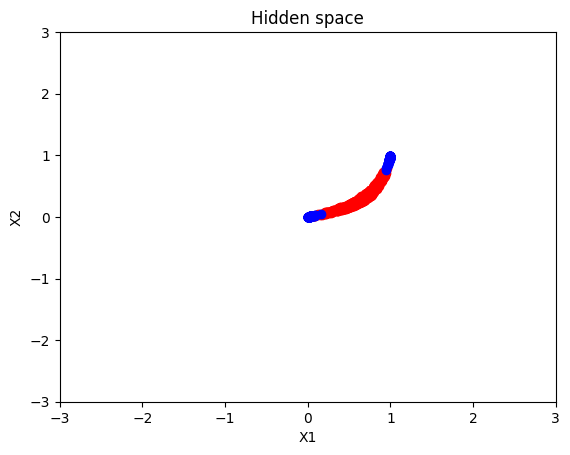

____________________________________________________________________________________________________


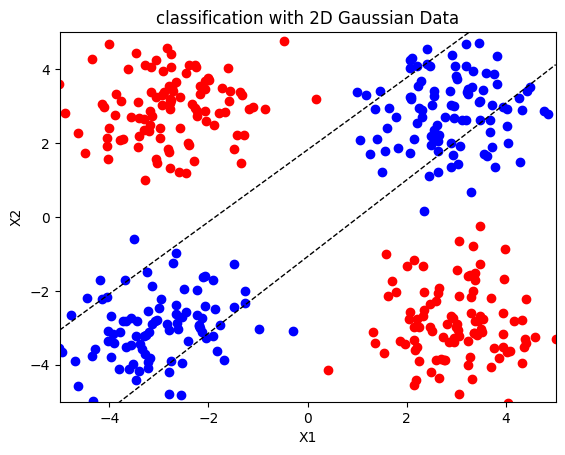

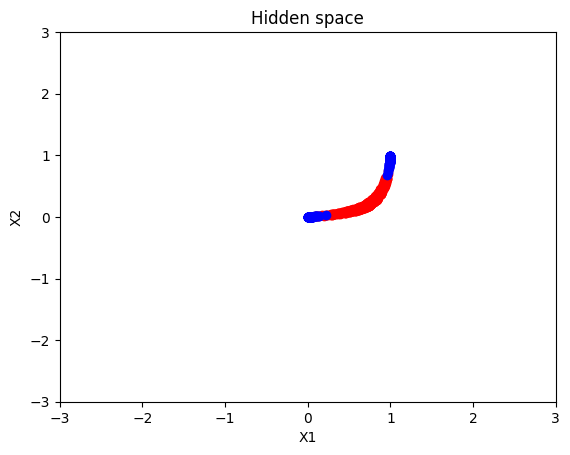

____________________________________________________________________________________________________


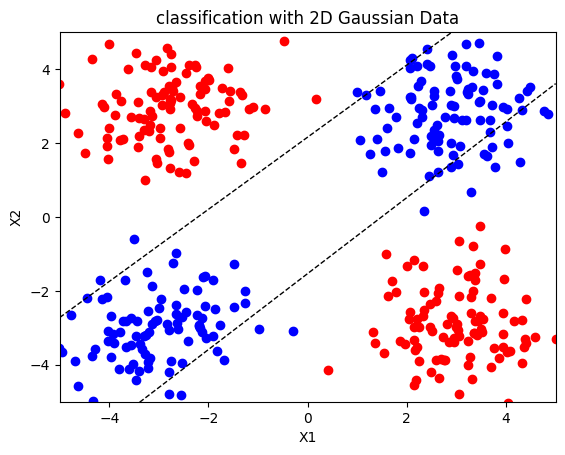

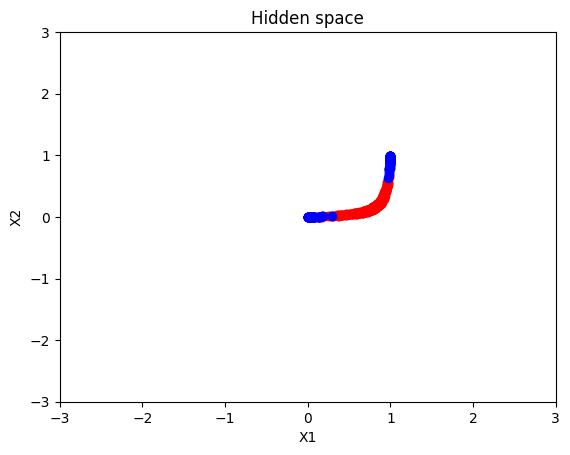

____________________________________________________________________________________________________


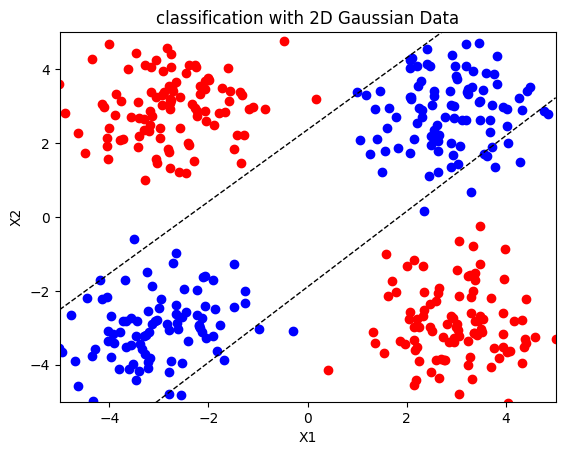

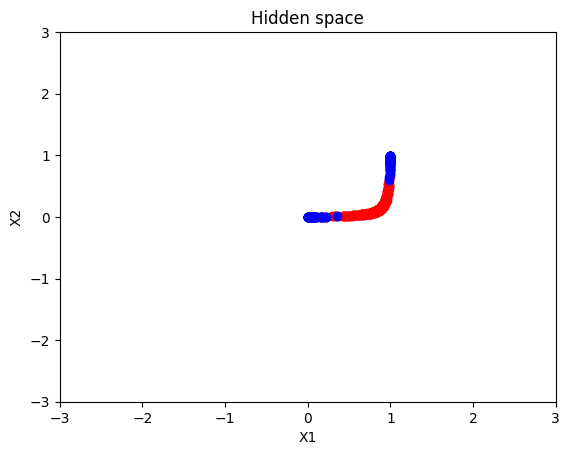

____________________________________________________________________________________________________


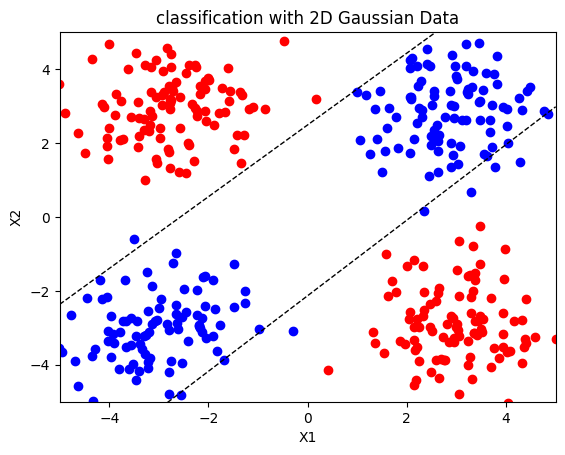

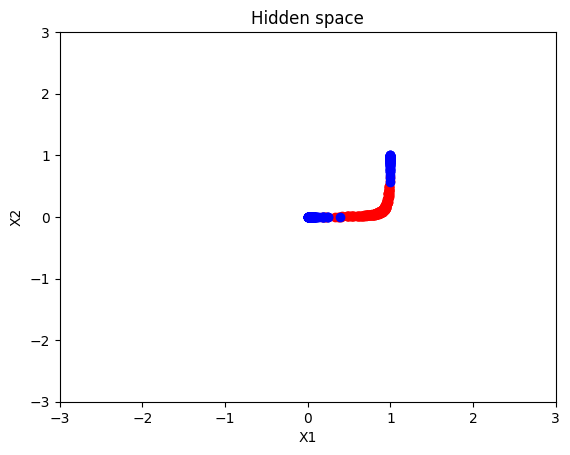

____________________________________________________________________________________________________


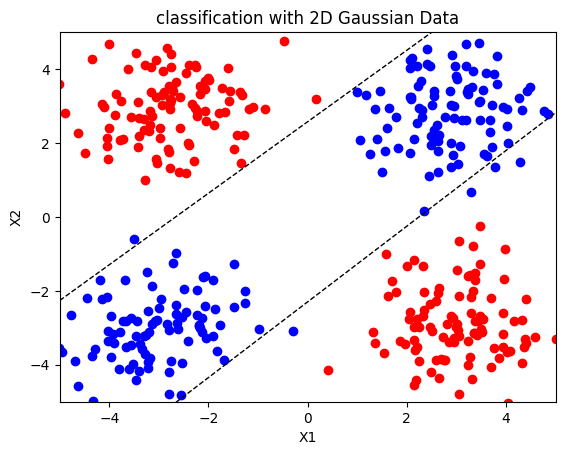

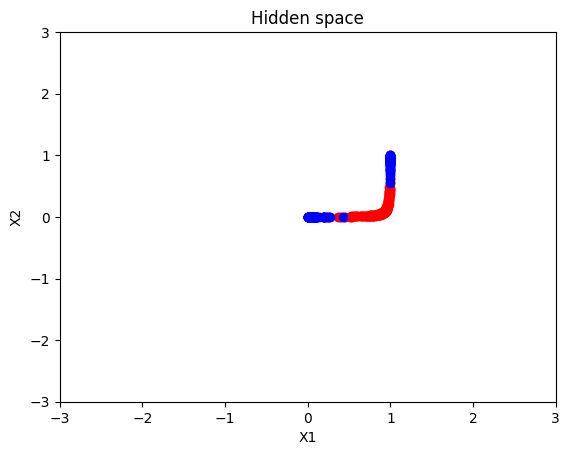

____________________________________________________________________________________________________


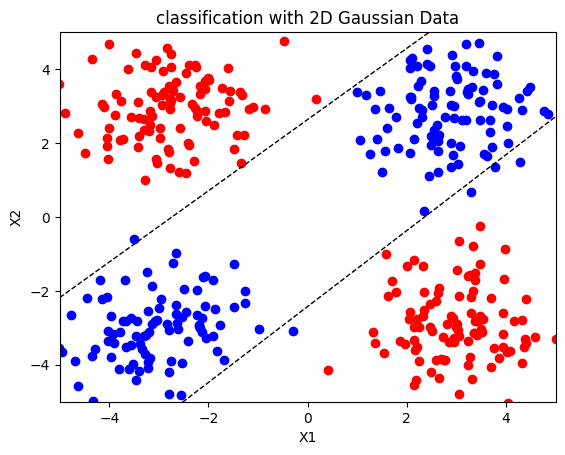

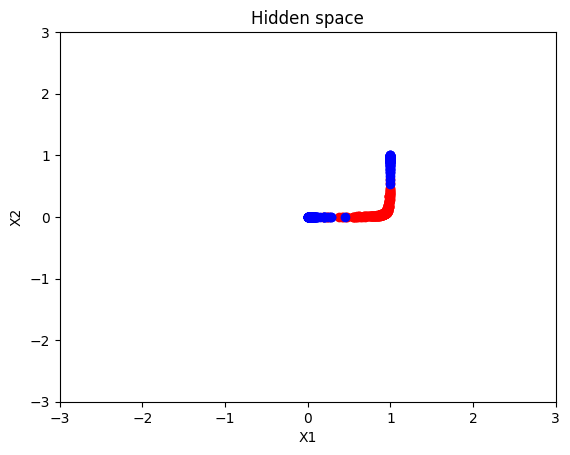

____________________________________________________________________________________________________


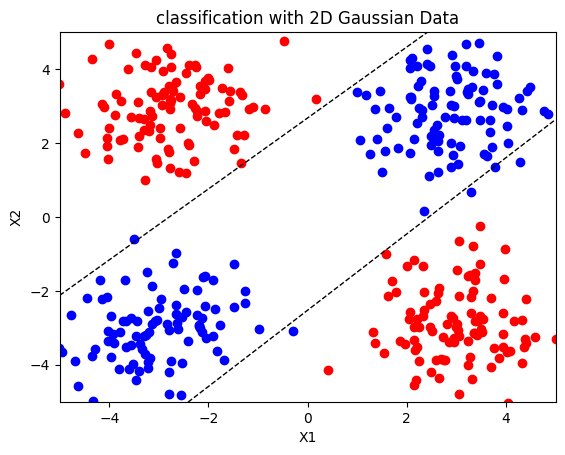

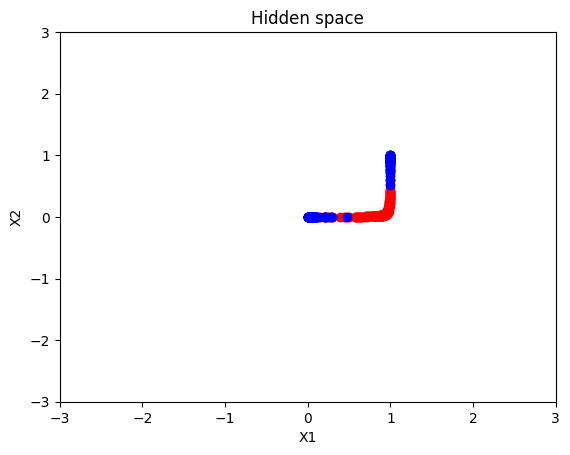

____________________________________________________________________________________________________


In [81]:
## Training loop
num_epochs = 1000
learning_rate = 0.1

for epoch in range(num_epochs):
    gradients = grad(binary_cross_entropy)(params, X_jax, y_jax)
    
    # Update parameters without using tree_multimap
    #params = (params[0] - learning_rate * gradients[0], params[1] - learning_rate * gradients[1])
    params = [param - learning_rate * gradient for param, gradient in zip(params, gradients)]
# Extract trained weights and bias

    if epoch % 100 == 0:
        wh1, bh1, wh2, bh2, wo, bo = params
        plot_things(data_red, data_blue, lines=[(wh1[0], wh1[1], bh1), (wh2[0], wh2[1], bh2)])
        plot_things(hidden_layer(params, X_jax)[:2*n], hidden_layer(params, X_jax)[2*n:], lines=[], range_lim=3, caption="Hidden space")
        print("_"*100)

In [82]:
# Print final accuracy
print("Final Accuracy:", (predict(params, X_jax) == y_jax).mean())


Final Accuracy: 0.97999996


### In fact what we want to learn is a XOR function

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

# Create all possible combinations of x1 and x2 (0 and 1)
combinations = [(0, 0), (0, 1), (1, 0), (1, 1)]

# Create a DataFrame
df = pd.DataFrame(combinations, columns=['x1', 'x2'])

# Add a third column with the XOR of x1 and x2
df['xor(x1, x2)'] = df['x1'] ^ df['x2']
df

x1  x2  xor(x1, x2)
0   0   0            0
1   0   1            1
2   1   0            1
3   1   1            0

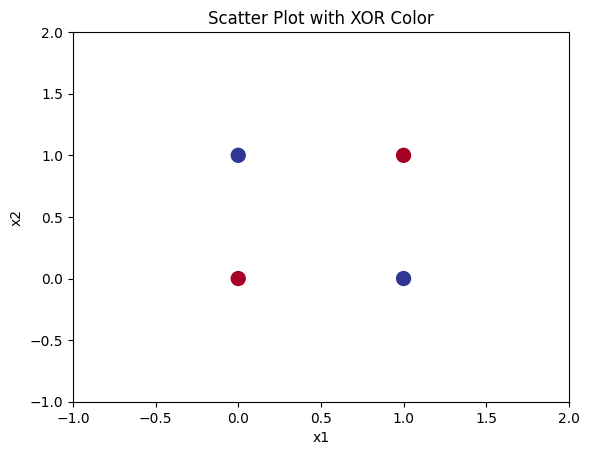

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# Create all possible combinations of x1 and x2 (0 and 1)
combinations = [(0, 0), (0, 1), (1, 0), (1, 1)]

# Create a DataFrame
df = pd.DataFrame(combinations, columns=['x1', 'x2'])

# Add a third column with the XOR of x1 and x2
df['xor'] = df['x1'] ^ df['x2']

# Scatter plot
plt.scatter(df['x1'], df['x2'], c=df['xor'], cmap='RdYlBu', s=100)

# Set labels and title
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Scatter Plot with XOR Color')

# Set axis ranges
plt.xlim(-1, 2)
plt.ylim(-1, 2)

# Show the plot
plt.show()


# Neural Networks as a way to approximate arbitrary functions

The Universal Approximation Theorem for neural networks is a fundamental result in the field of machine learning that was first proven by George Cybenko in 1989 and later extended by Kurt Hornik in 1991. The theorem states that a feedforward neural network with a single hidden layer containing a sufficient number of neurons can approximate any continuous function on a compact input space to arbitrary precision.

In other words, the Universal Approximation Theorem asserts that neural networks, specifically those with a single hidden layer, are powerful enough to approximate any continuous function. The key requirements for the theorem to hold are:

1. **Activation Function:** The activation function used in the neurons must be non-constant, bounded, and piecewise continuous. Common activation functions that satisfy these criteria include sigmoid, hyperbolic tangent (tanh), and rectified linear unit (ReLU).

2. **Sufficient Number of Neurons:** The single hidden layer must have a sufficient number of neurons. The exact number needed depends on the complexity of the function being approximated. The theorem doesn't provide a specific formula for determining the minimum number of neurons but establishes the existence of such a number.

It's important to note that while the Universal Approximation Theorem demonstrates the expressive power of neural networks, it doesn't provide guidance on practical aspects of training or the choice of architecture for real-world problems. In practice, deeper networks with multiple hidden layers are commonly used, and techniques like regularization and proper initialization are employed to ensure effective training and generalization.

# Neural Networks as a method to learn arbitrary functions

## Learning circle

In [85]:
import numpy as np
import matplotlib.pyplot as plt

N44 = 100
# Set a seed for reproducibility
np.random.seed(44)

# 1. Create a synthetic dataset of 100 random points on -1, 1 interval in 2 dimensions
points_interval = np.zeros((N44, 2))
points_interval[:,0] = np.linspace(-1,1, N44)
points_interval[:,1] = 0
points_interval = points_interval +  np.random.normal(size=(N44,2)) * 0


# 2. Create a synthetic dataset of 100 random points on a radius 1 circle in 2 dimensions
theta = np.linspace(0, 2 * np.pi, N44)
radius = 1
points_circle = np.column_stack([radius * np.cos(theta), radius * np.sin(theta)])
points_circle = points_circle + np.random.normal(size=(N44,2)) * 0.0


/var/folders/jb/f121_ltj0fb06y61hfq9sz5c0000gn/T/ipykernel_23851/1490713145.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(points_interval[random_indices, 0], points_interval[random_indices, 1], cmap='viridis')


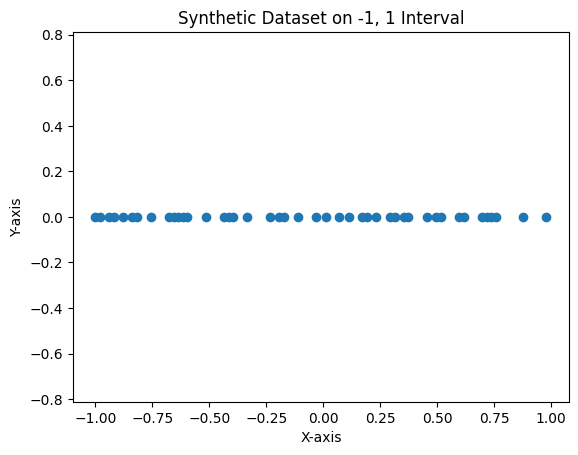

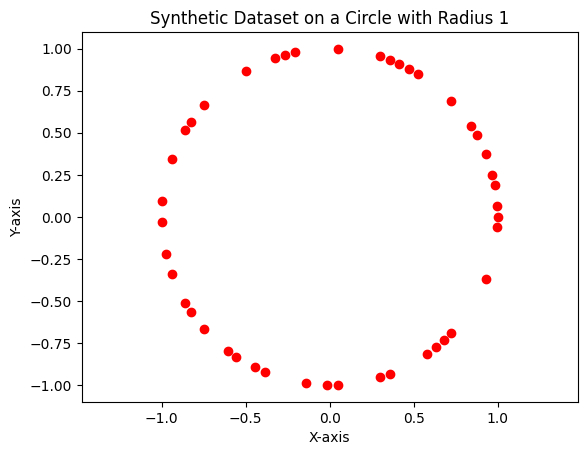

In [86]:

random_indices = np.random.choice(N44, 44, replace=False)

# Scatterplot for the first dataset
plt.scatter(points_interval[random_indices, 0], points_interval[random_indices, 1], cmap='viridis')
plt.axis('equal')

plt.title('Synthetic Dataset on -1, 1 Interval')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


# Scatterplot for the second dataset
plt.scatter(points_circle[random_indices, 0], points_circle[random_indices, 1], color='red')
plt.title('Synthetic Dataset on a Circle with Radius 1')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axis('equal')  # Ensure equal scaling for x and y axes to visualize the circle properly
plt.show()

## Warmup, learning sinus 

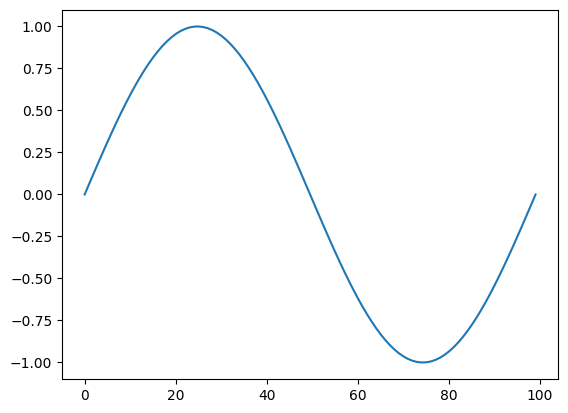

In [87]:
plt.plot(points_circle[:,1])
plt.show()

In [89]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

# Set a random seed for reproducibility
key = random.PRNGKey(0)

# Define the neural network model
def neural_network(params, x):
    w1, b1, w2, b2 = params
    hidden = jnp.tanh(jnp.dot(x, w1) + b1)
    return jnp.dot(hidden, w2) + b2

# Define the mean squared error loss function
def mean_squared_error(params, x, y_true):
    y_pred = neural_network(params, x)
    return jnp.mean((y_pred - y_true)**2)

# Initialize the neural network parameters
key, subkey = random.split(key)

input_dim = 1
hidden_dim = 12
output_dim = 1
params = [
            random.normal(subkey, (input_dim, hidden_dim)),  random.normal(subkey, (hidden_dim,)),
            random.normal(subkey, (hidden_dim, output_dim)), random.normal(subkey, (output_dim,))
        ]
mems = [ jnp.zeros_like(param) for param in params]


# Gradient of the loss with respect to the parameters
grad_loss = grad(mean_squared_error)

In [90]:
x = points_interval[:,[0]]
sin = points_circle[:,[0]]

X = x
y = sin

Epoch 0, Loss: 27.78514289855957


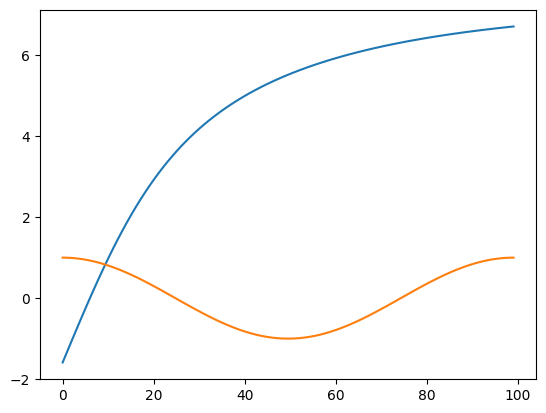

Epoch 100, Loss: 0.6741384863853455


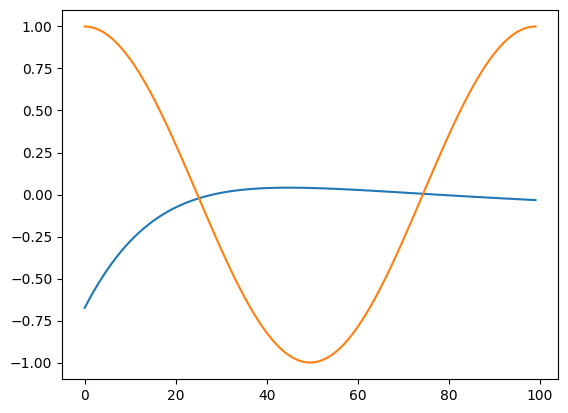

Epoch 200, Loss: 0.5697692036628723


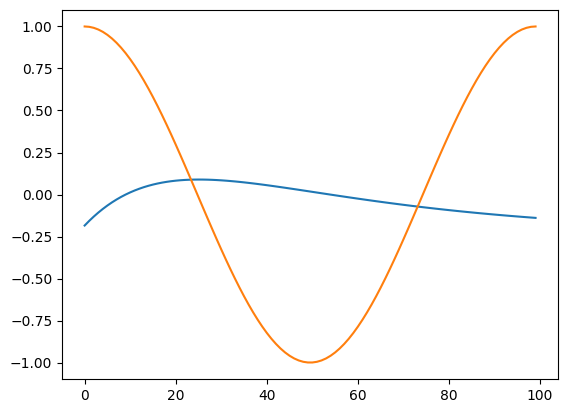

Epoch 300, Loss: 0.5362743735313416


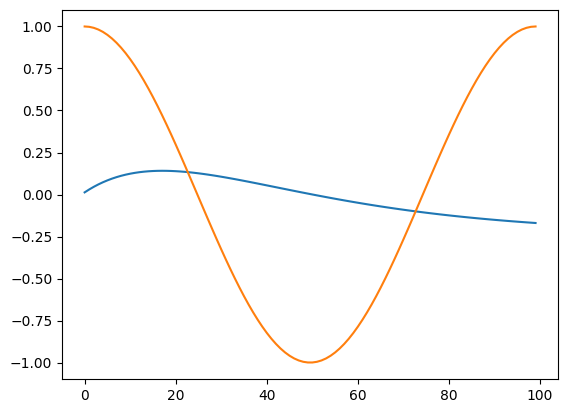

Epoch 400, Loss: 0.5158718228340149


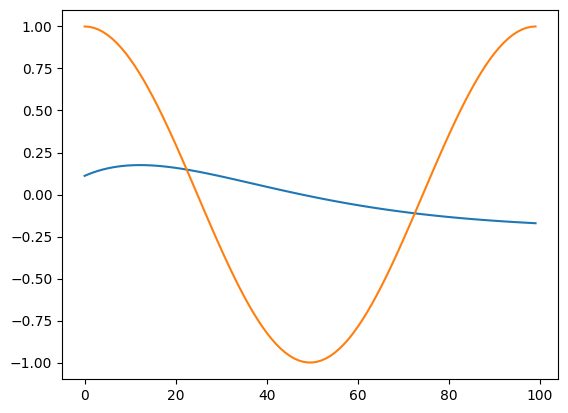

Epoch 500, Loss: 0.49906402826309204


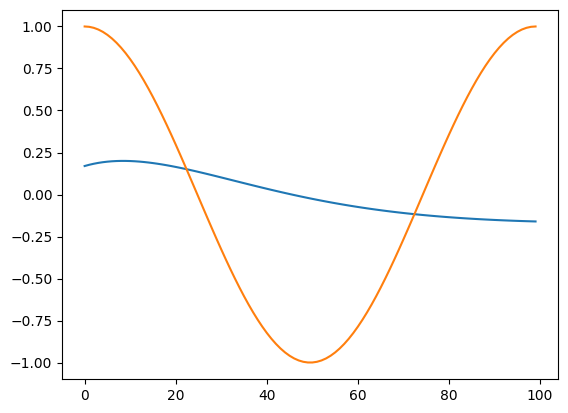

Epoch 600, Loss: 0.48320648074150085


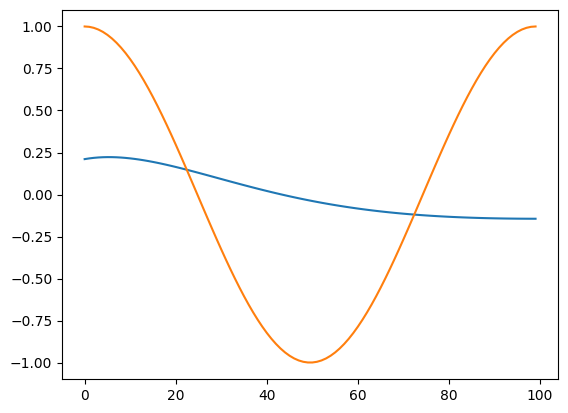

Epoch 700, Loss: 0.46701788902282715


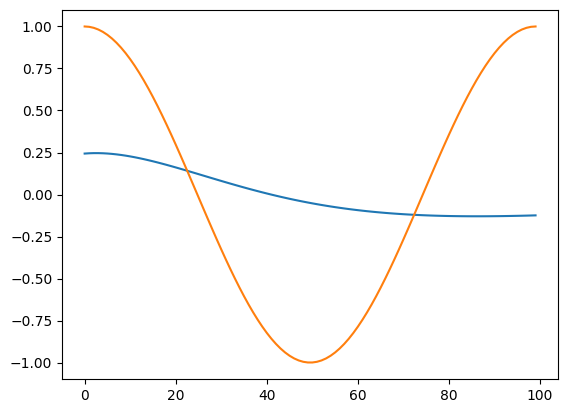

Epoch 800, Loss: 0.44960227608680725


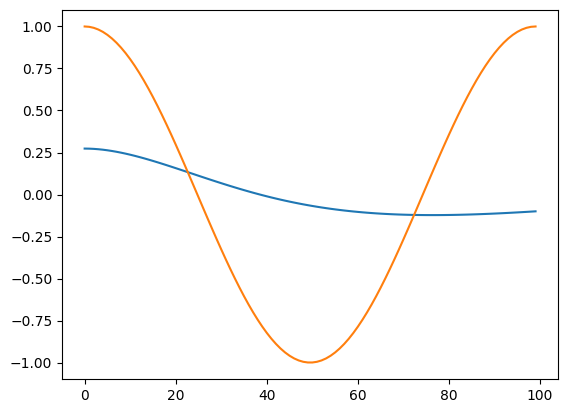

Epoch 900, Loss: 0.43023061752319336


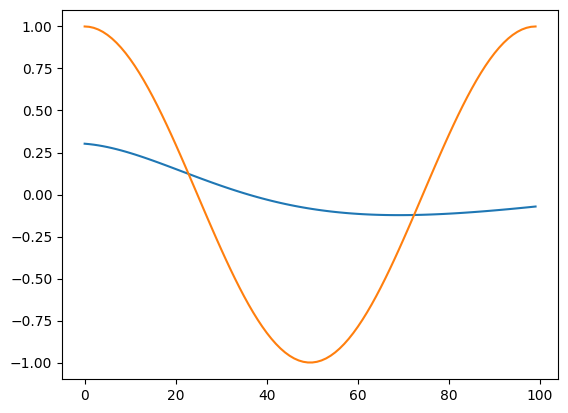

Epoch 1000, Loss: 0.4082963466644287


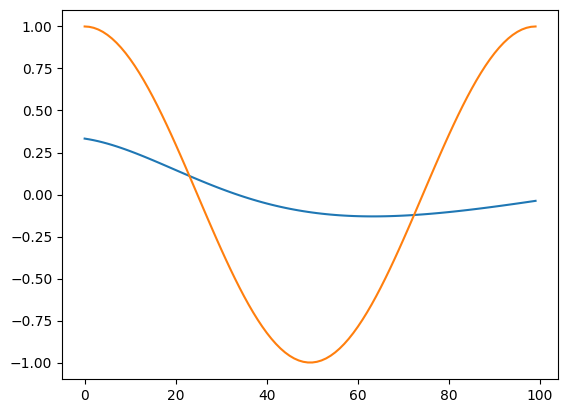

Epoch 1100, Loss: 0.38333743810653687


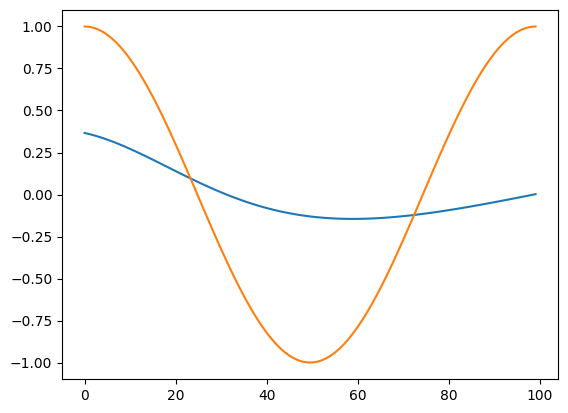

Epoch 1200, Loss: 0.3550970256328583


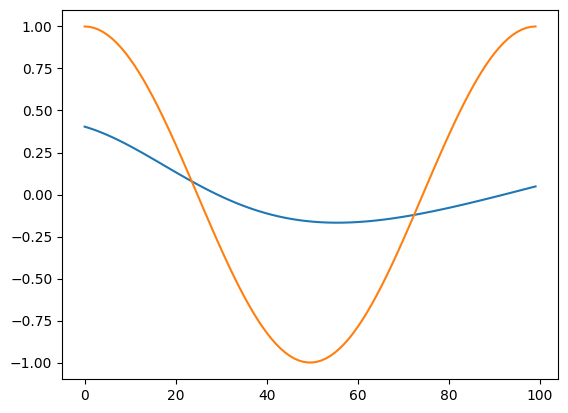

Epoch 1300, Loss: 0.3236086666584015


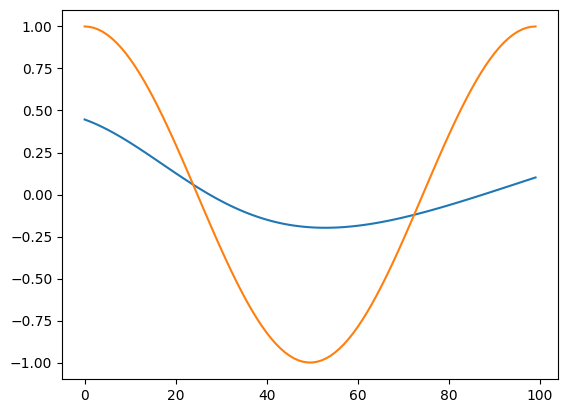

Epoch 1400, Loss: 0.28927910327911377


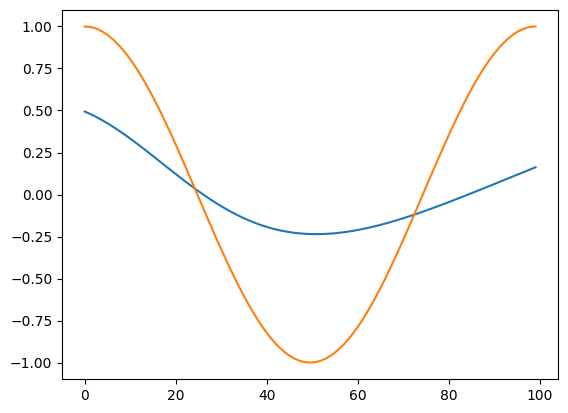

Epoch 1500, Loss: 0.25293269753456116


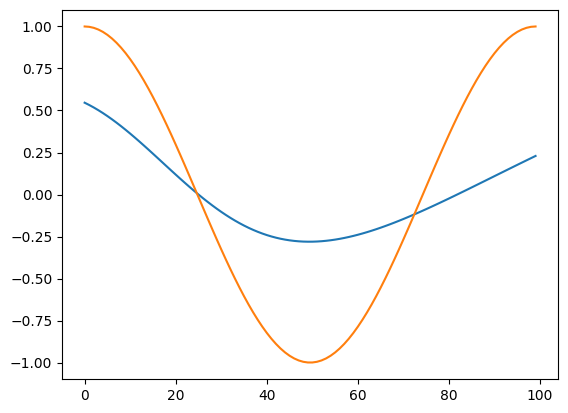

Epoch 1600, Loss: 0.21577835083007812


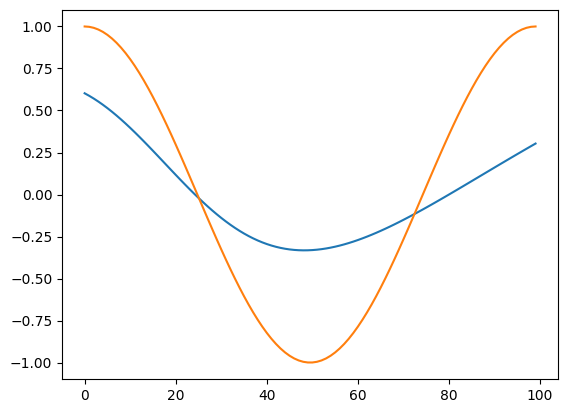

Epoch 1700, Loss: 0.17928123474121094


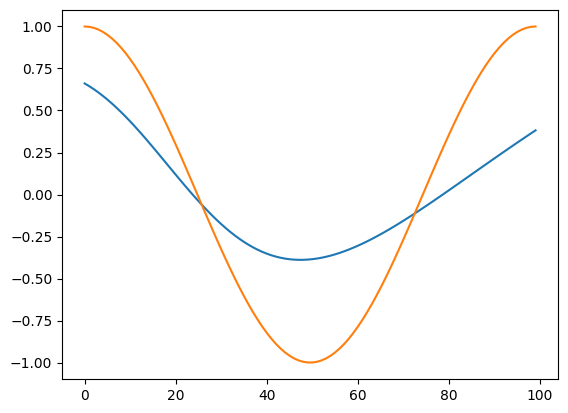

Epoch 1800, Loss: 0.14495287835597992


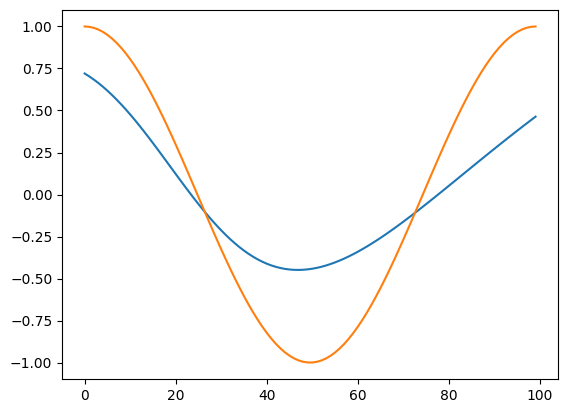

Epoch 1900, Loss: 0.11410469561815262


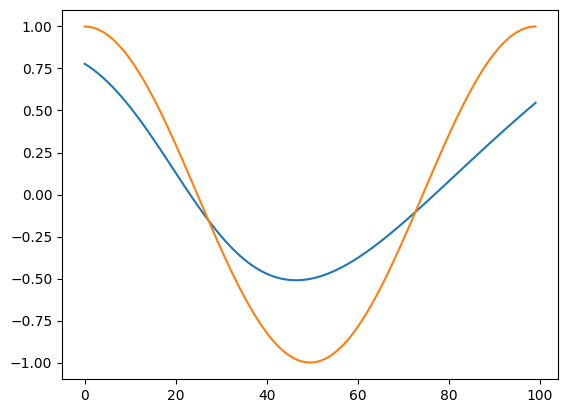

Epoch 2000, Loss: 0.08763747662305832


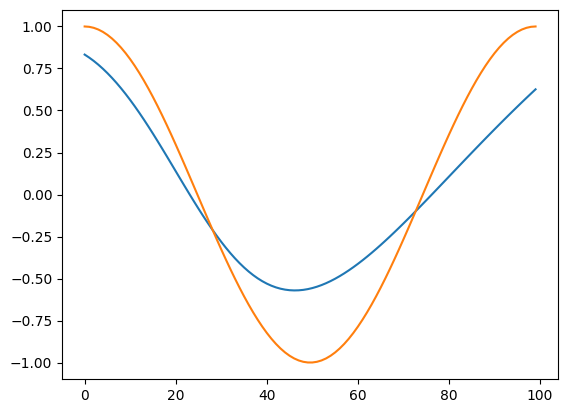

Epoch 2100, Loss: 0.06592949479818344


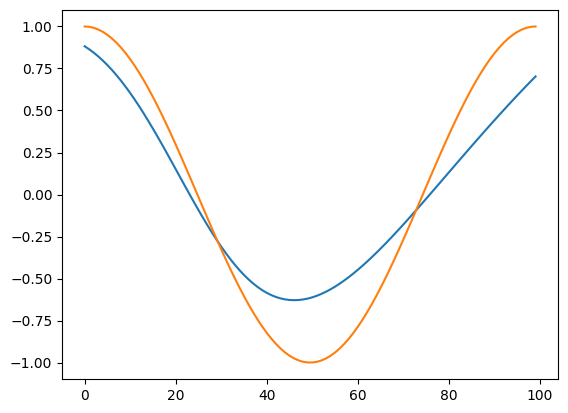

Epoch 2200, Loss: 0.04885454103350639


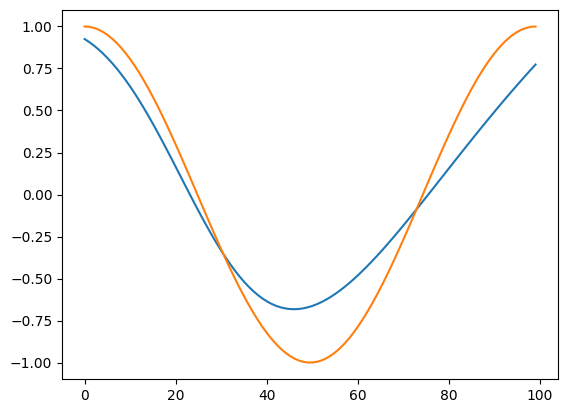

Epoch 2300, Loss: 0.03590806946158409


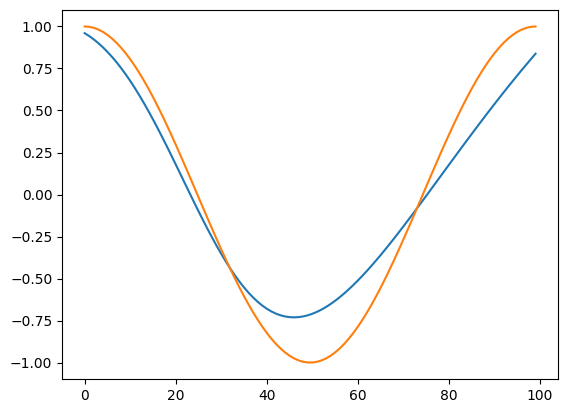

Epoch 2400, Loss: 0.02638249285519123


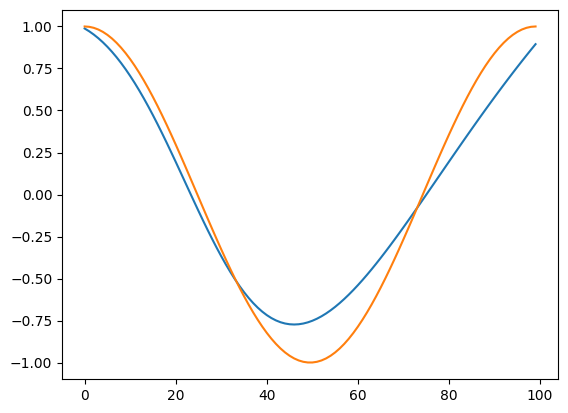

Epoch 2500, Loss: 0.01952938176691532


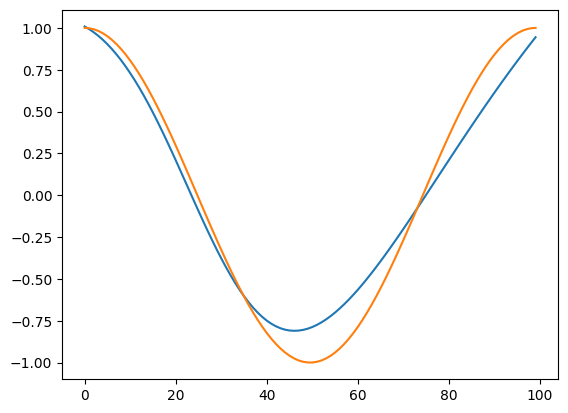

Epoch 2600, Loss: 0.014670168980956078


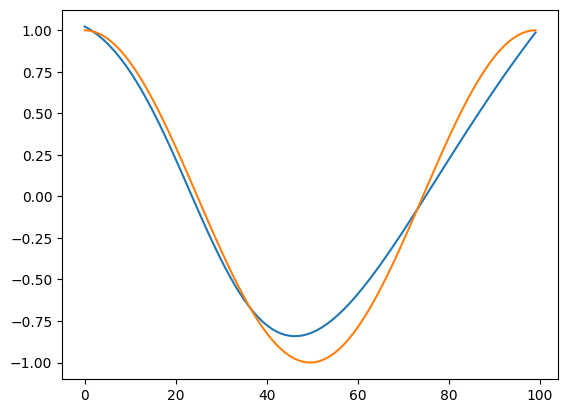

Epoch 2700, Loss: 0.0112493010237813


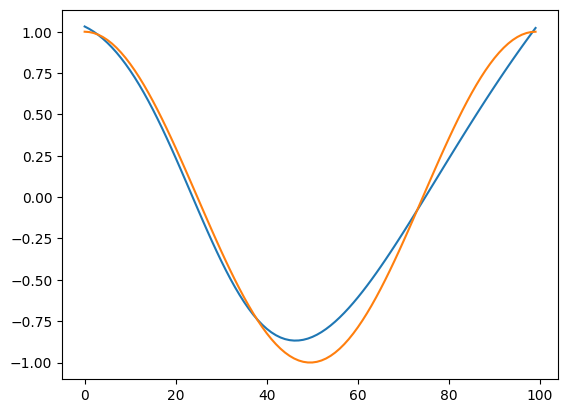

Epoch 2800, Loss: 0.008843239396810532


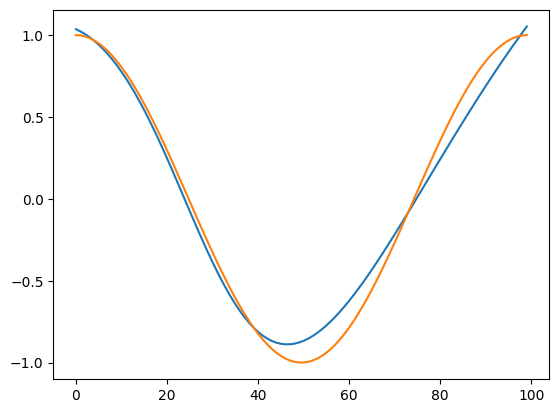

Epoch 2900, Loss: 0.007144696544855833


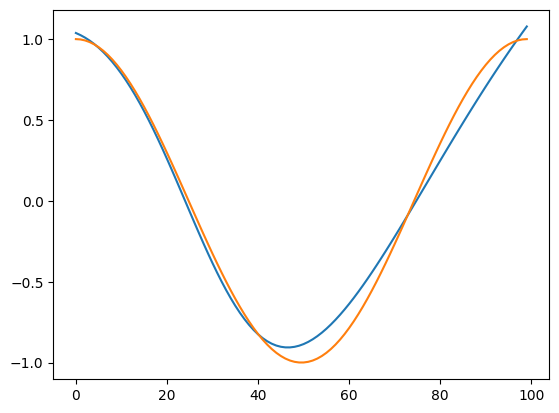

Epoch 3000, Loss: 0.005937802139669657


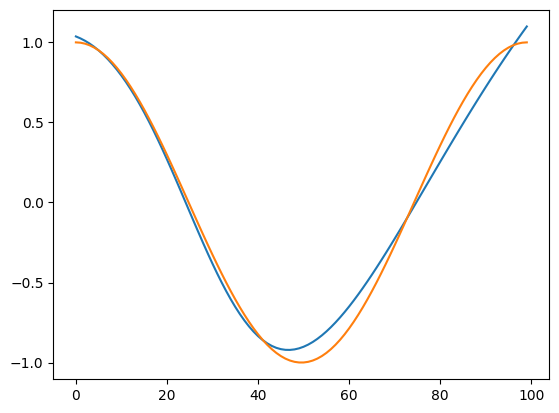

Epoch 3100, Loss: 0.005073488224297762


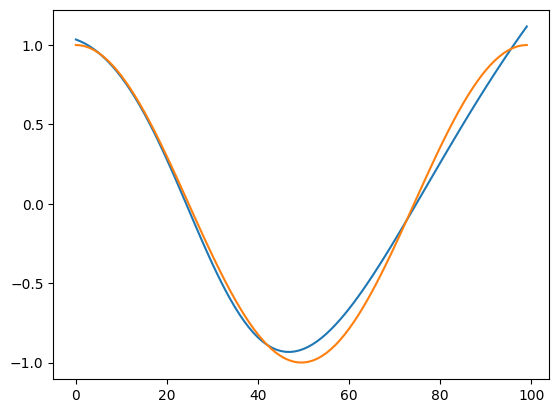

Epoch 3200, Loss: 0.004449605476111174


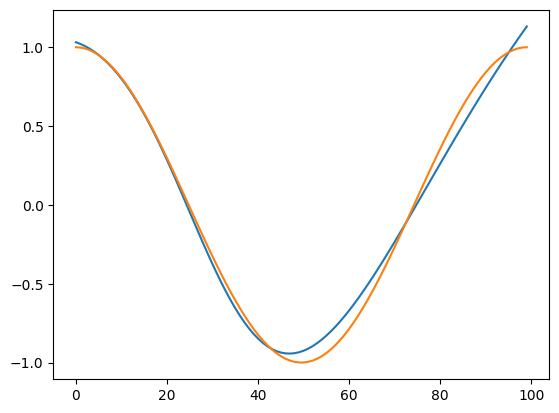

Epoch 3300, Loss: 0.00399593124166131


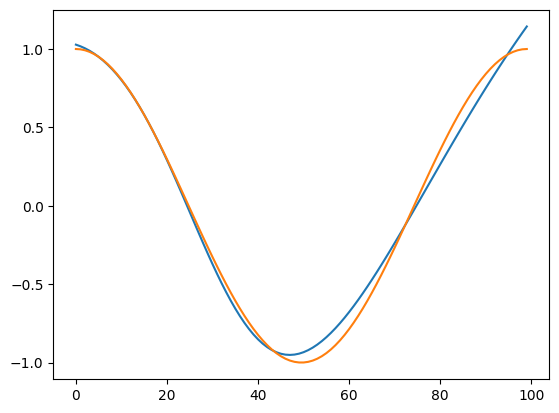

Epoch 3400, Loss: 0.00366380182094872


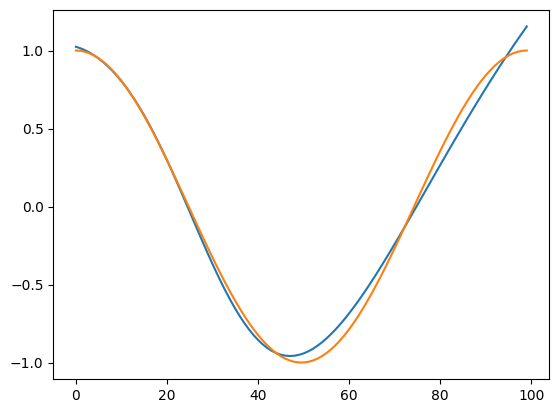

Epoch 3500, Loss: 0.0034191645681858063


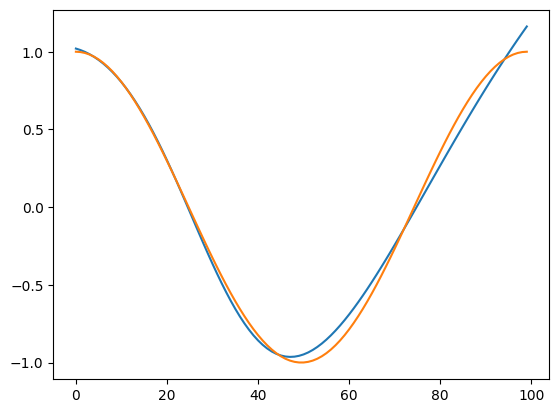

Epoch 3600, Loss: 0.0032378733158111572


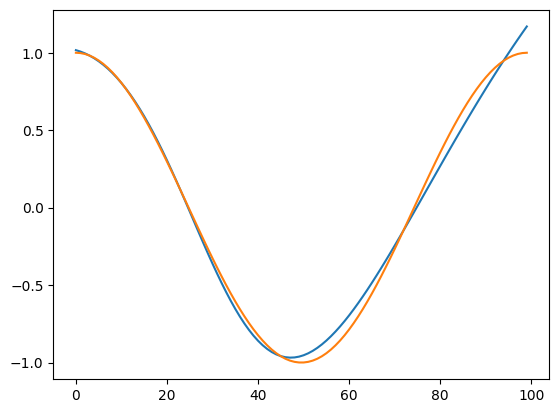

Epoch 3700, Loss: 0.003102684859186411


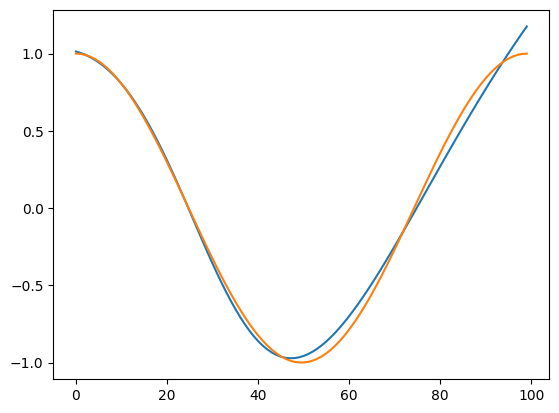

Epoch 3800, Loss: 0.0030011257622390985


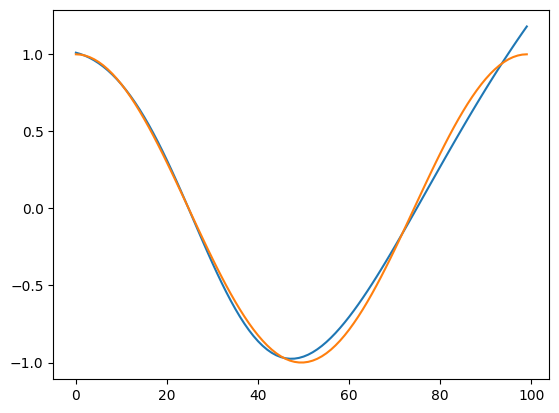

Epoch 3900, Loss: 0.0029241815209388733


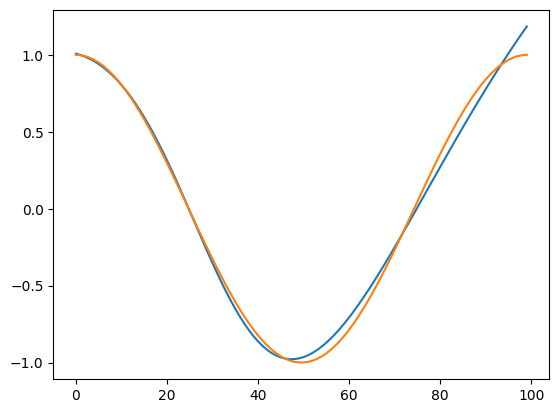

Epoch 4000, Loss: 0.0028652541805058718


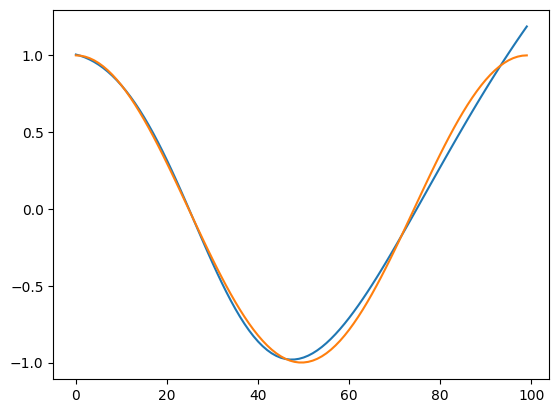

Epoch 4100, Loss: 0.002819538116455078


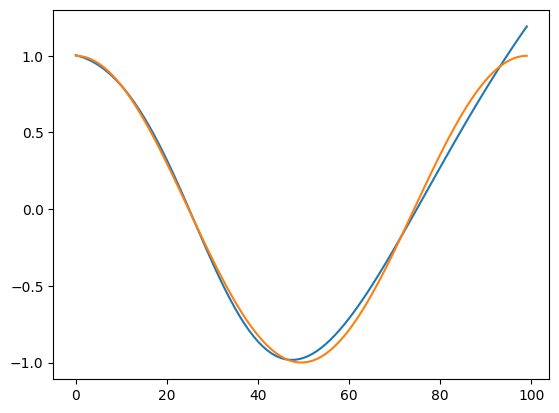

Epoch 4200, Loss: 0.002783514093607664


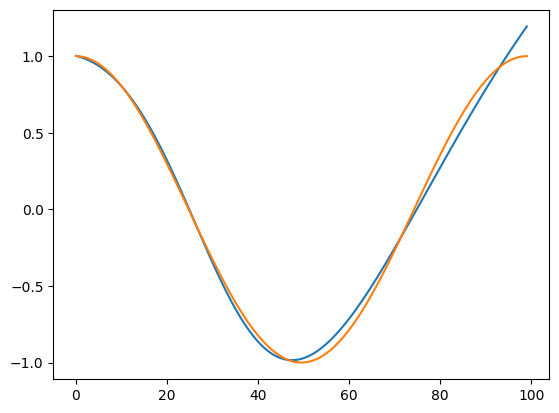

Epoch 4300, Loss: 0.0027545979246497154


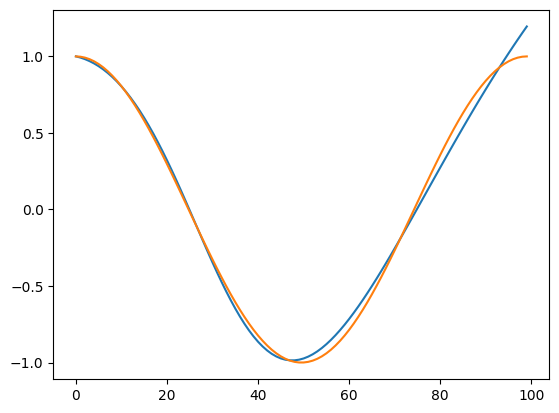

Epoch 4400, Loss: 0.0027308969292789698


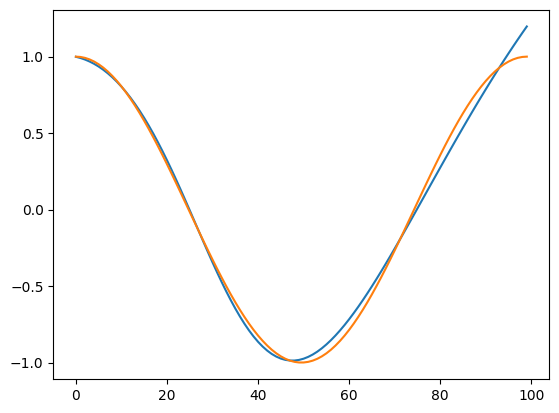

Epoch 4500, Loss: 0.002711015520617366


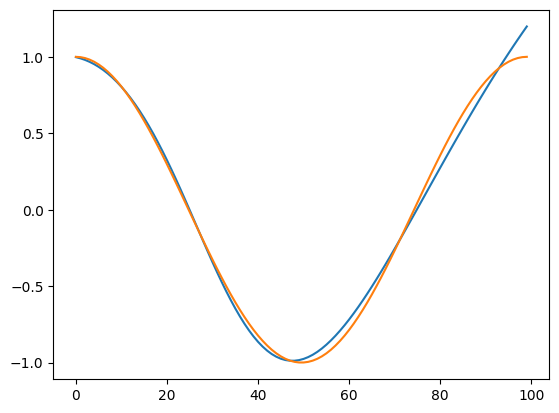

Epoch 4600, Loss: 0.002693952526897192


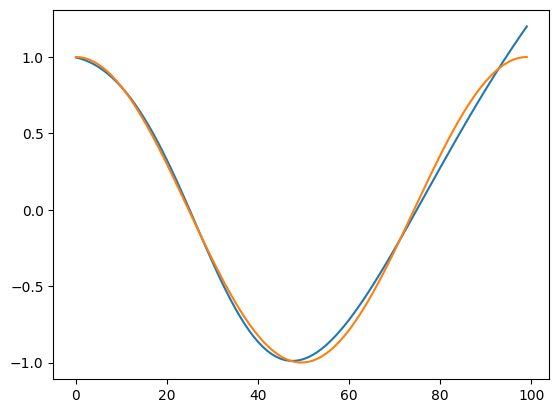

Epoch 4700, Loss: 0.002678953344002366


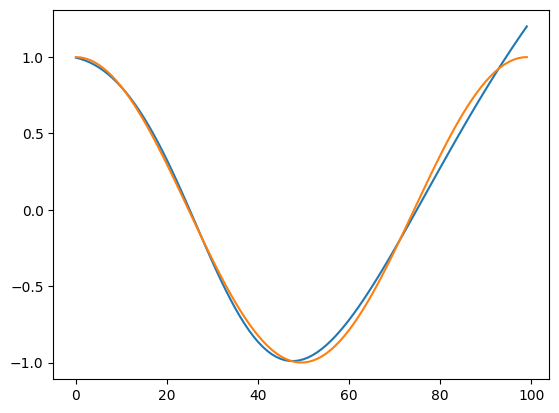

Epoch 4800, Loss: 0.0026654836256057024


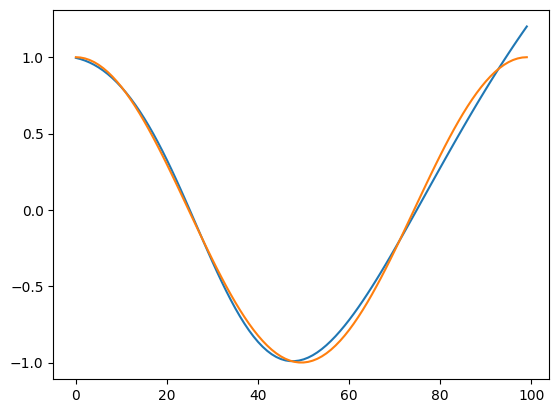

Epoch 4900, Loss: 0.0026531328912824392


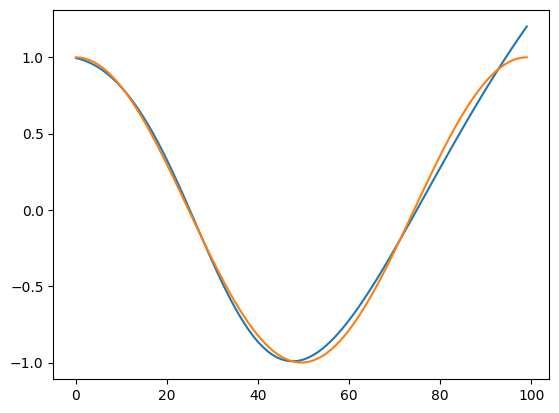

Epoch 5000, Loss: 0.002641629194840789


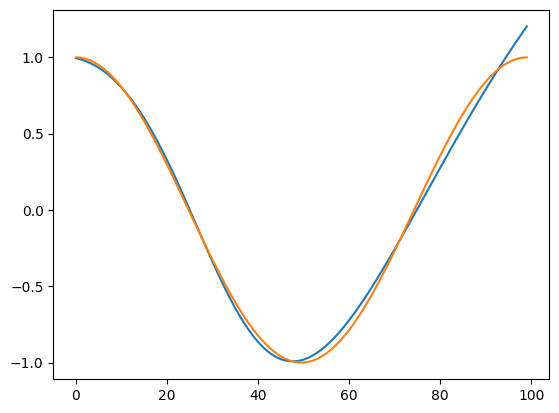

Epoch 5100, Loss: 0.0026307296939194202


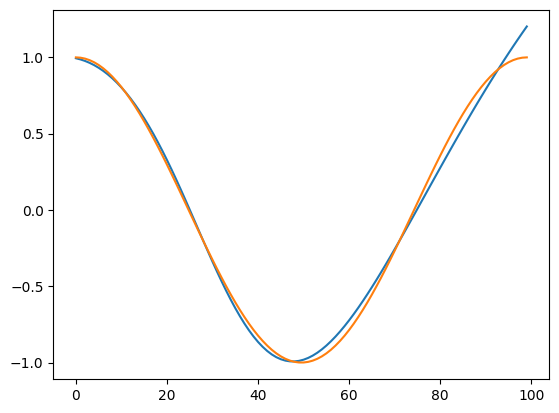

Epoch 5200, Loss: 0.0026203044690191746


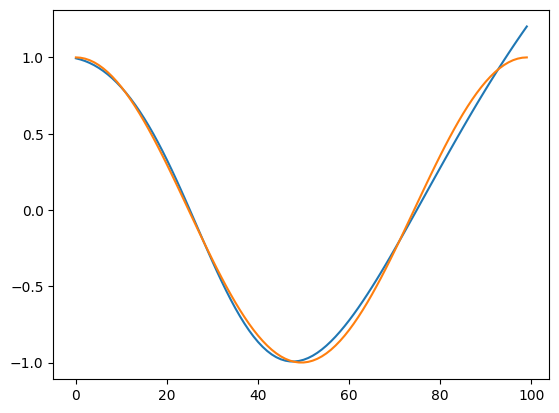

Epoch 5300, Loss: 0.0026102131232619286


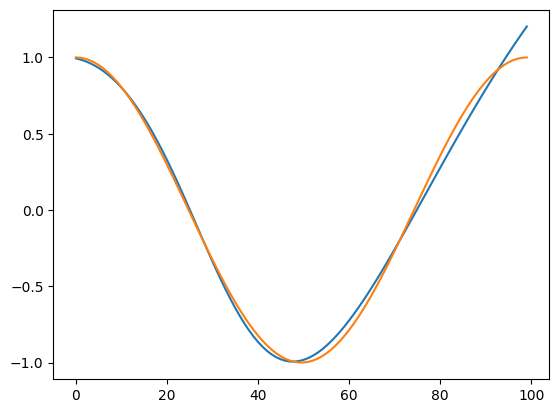

Epoch 5400, Loss: 0.002600395353510976


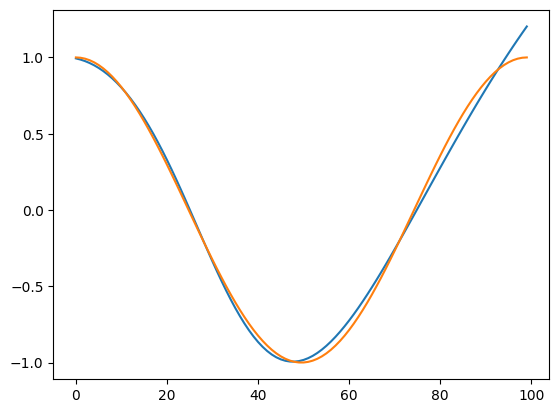

Epoch 5500, Loss: 0.0025907859671860933


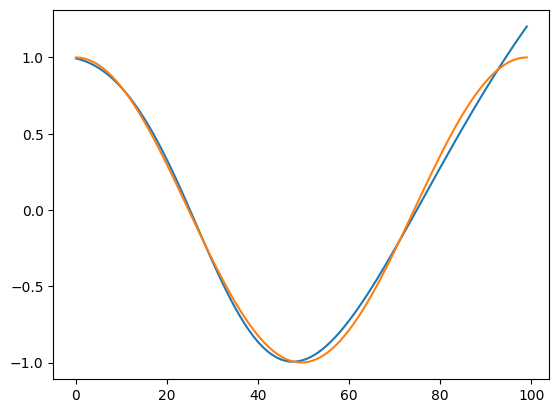

Epoch 5600, Loss: 0.0025813423562794924


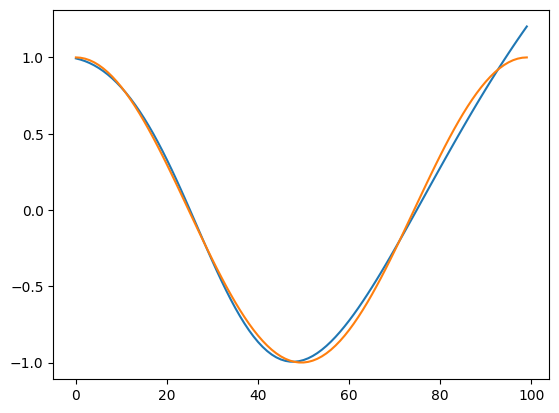

Epoch 5700, Loss: 0.0025720277335494757


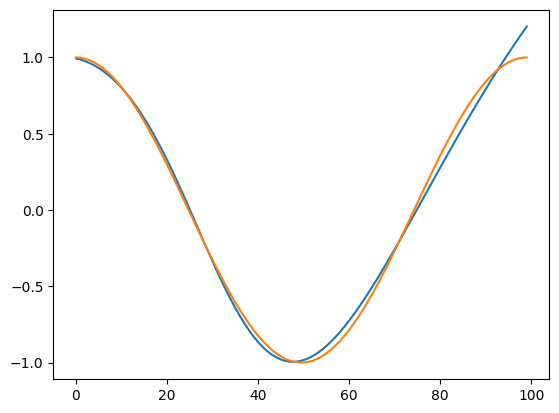

Epoch 5800, Loss: 0.0025628190487623215


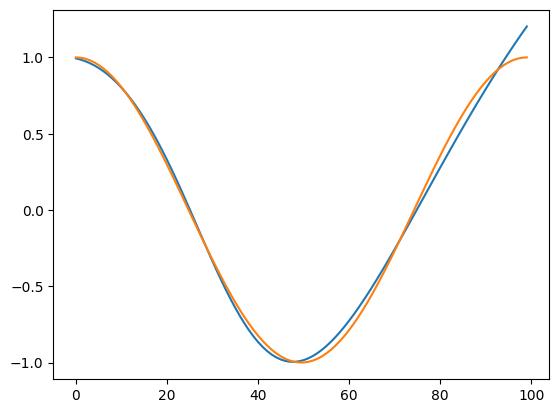

Epoch 5900, Loss: 0.002553700702264905


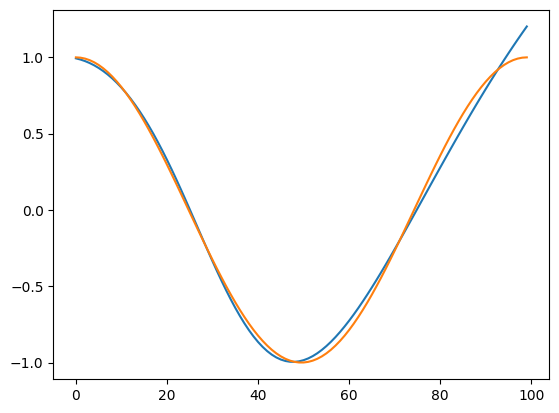

Epoch 6000, Loss: 0.0025446468498557806


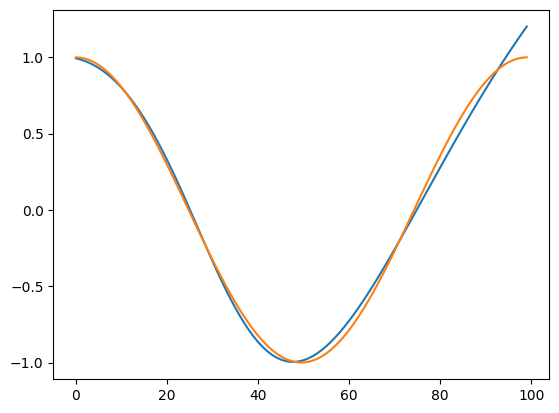

Epoch 6100, Loss: 0.002535670530050993


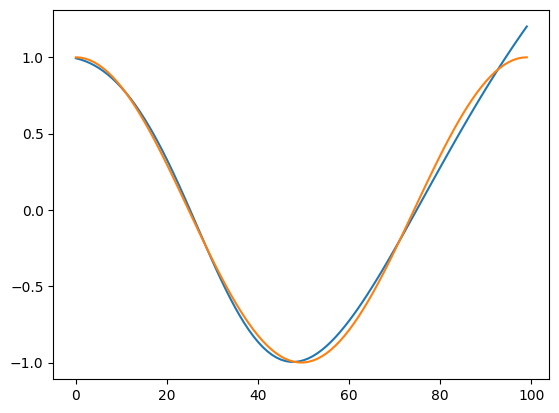

Epoch 6200, Loss: 0.002526749623939395


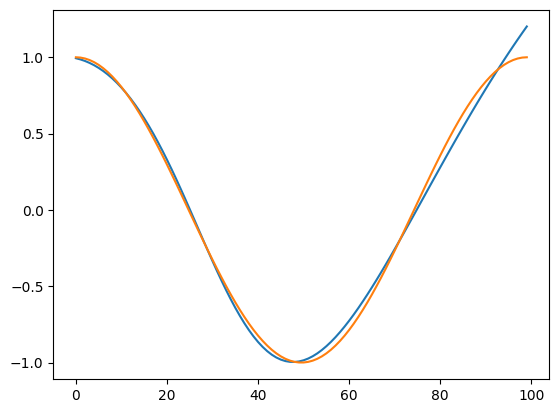

Epoch 6300, Loss: 0.0025178855285048485


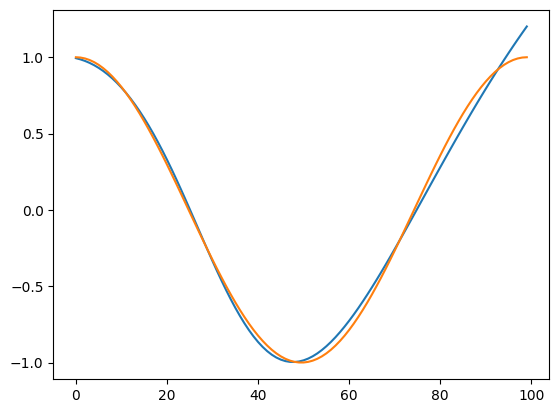

Epoch 6400, Loss: 0.0025090717244893312


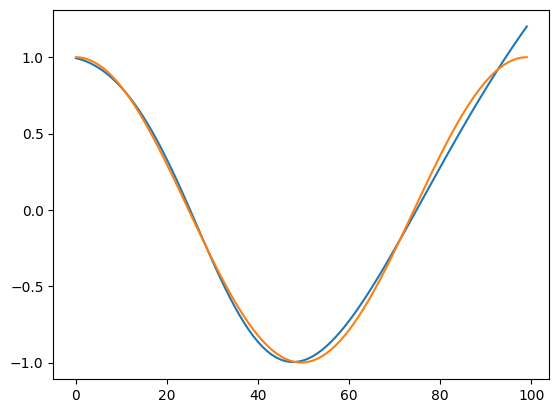

Epoch 6500, Loss: 0.002500321716070175


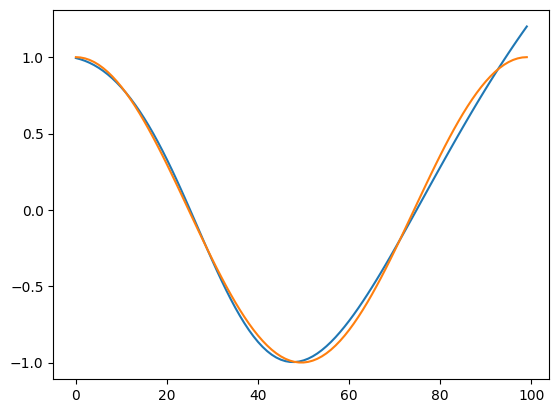

Epoch 6600, Loss: 0.0024916057009249926


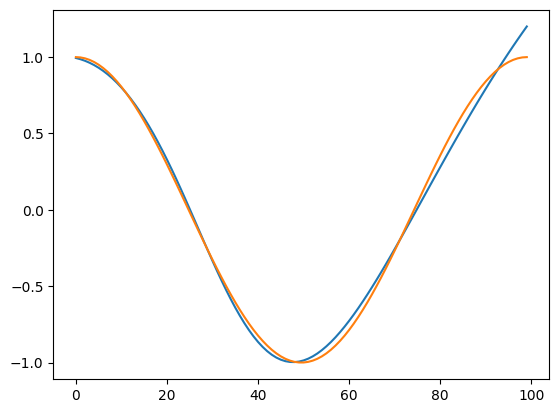

Epoch 6700, Loss: 0.0024829416070133448


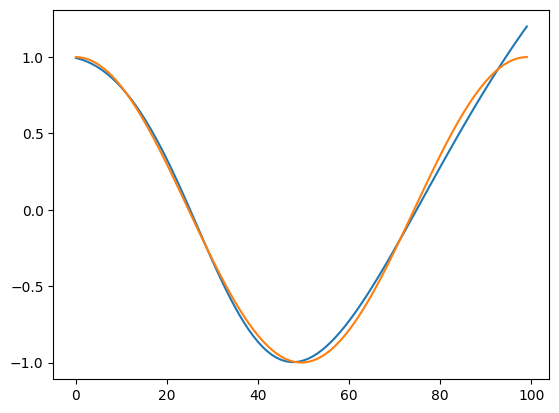

Epoch 6800, Loss: 0.0024743201211094856


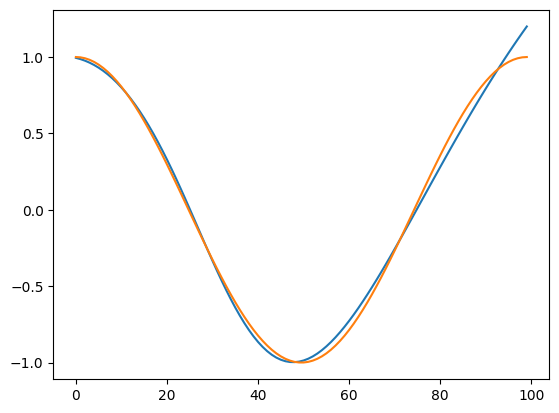

Epoch 6900, Loss: 0.0024657449685037136


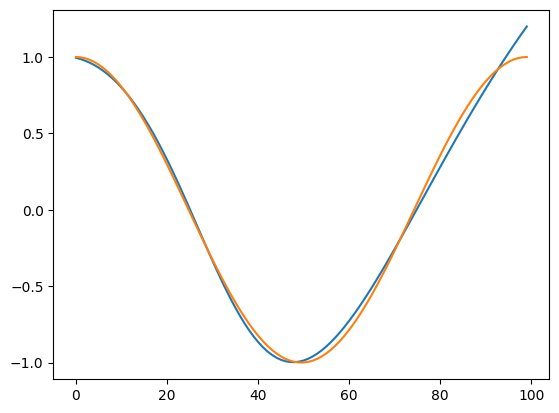

Epoch 7000, Loss: 0.002457205206155777


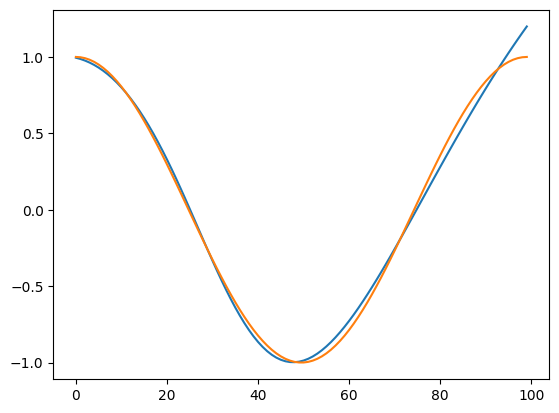

Epoch 7100, Loss: 0.0024487238842993975


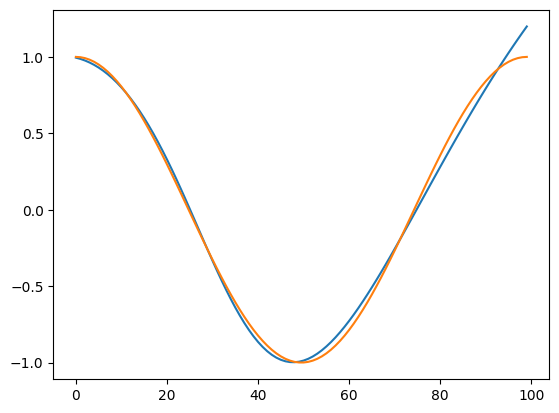

Epoch 7200, Loss: 0.002440279582515359


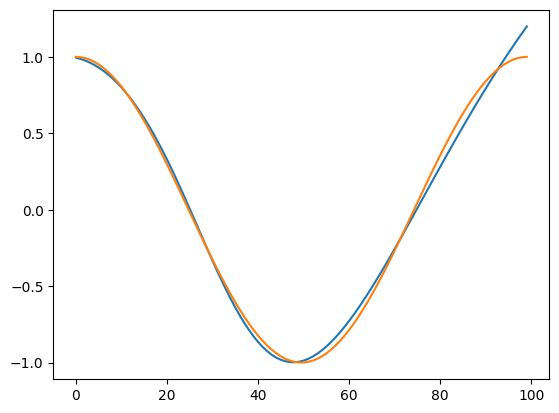

Epoch 7300, Loss: 0.002431892789900303


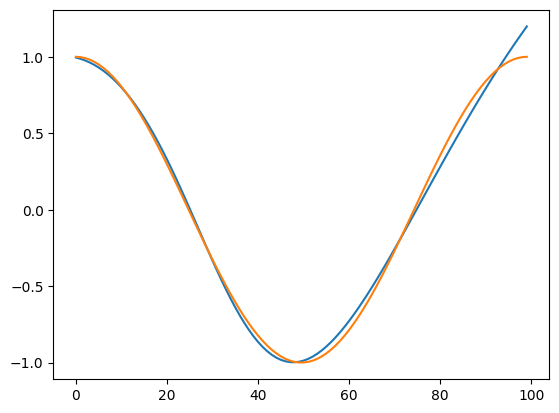

Epoch 7400, Loss: 0.0024235397577285767


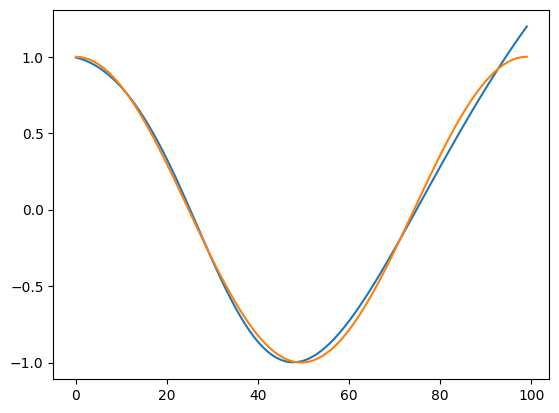

Epoch 7500, Loss: 0.0024152377154678106


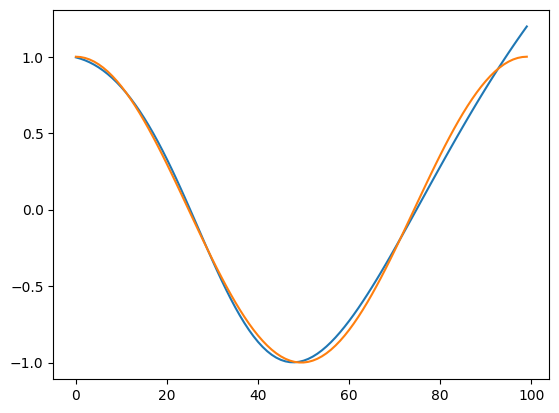

Epoch 7600, Loss: 0.0024069775827229023


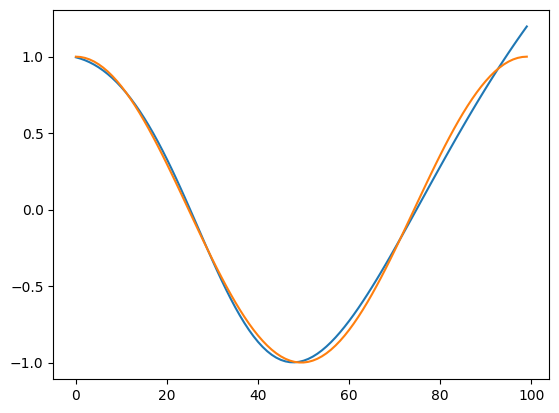

Epoch 7700, Loss: 0.0023987621534615755


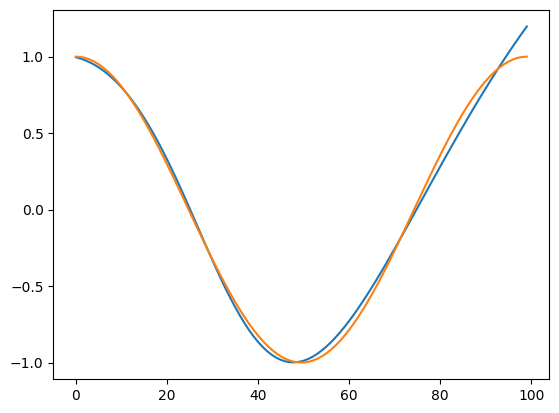

Epoch 7800, Loss: 0.0023905846755951643


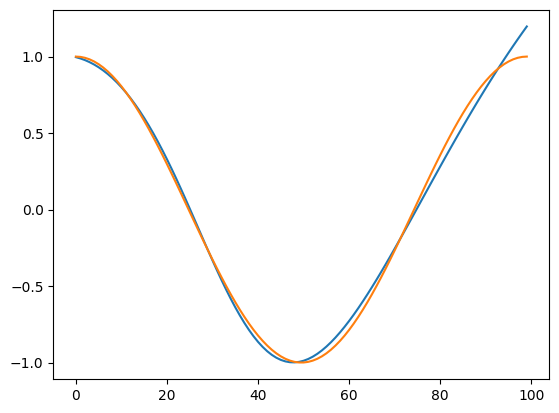

Epoch 7900, Loss: 0.0023824514355510473


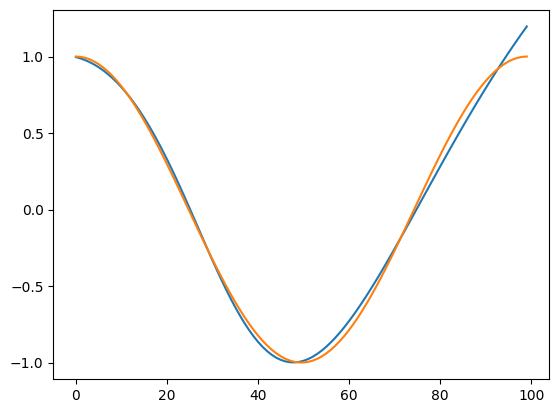

Epoch 8000, Loss: 0.0023743610363453627


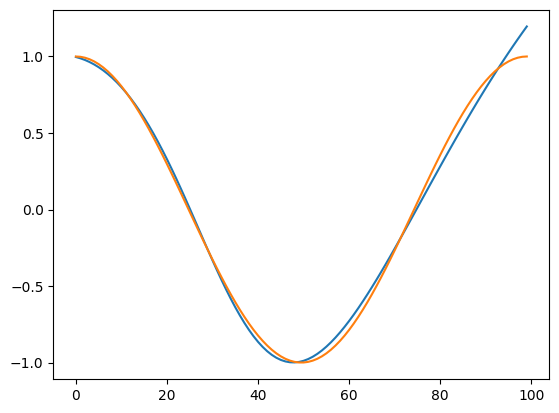

Epoch 8100, Loss: 0.0023663209285587072


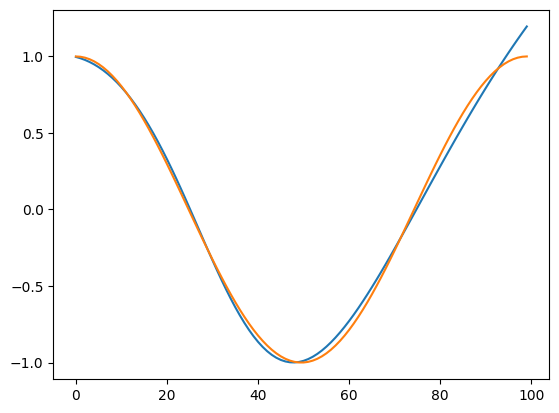

Epoch 8200, Loss: 0.002358314348384738


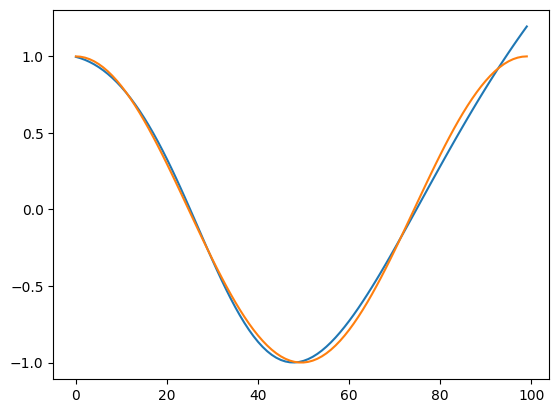

Epoch 8300, Loss: 0.002350355964154005


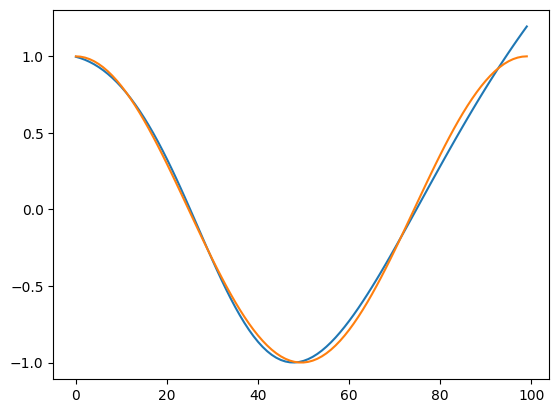

Epoch 8400, Loss: 0.002342450665310025


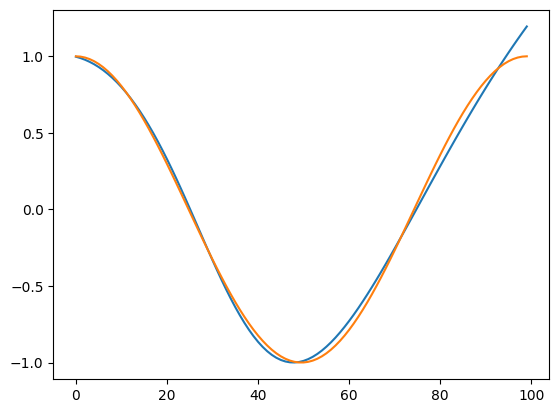

Epoch 8500, Loss: 0.0023345835506916046


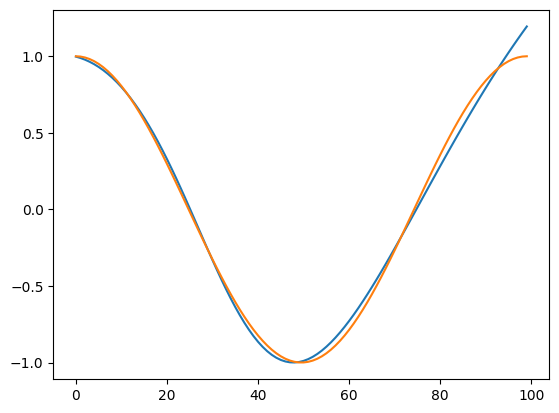

Epoch 8600, Loss: 0.002326756017282605


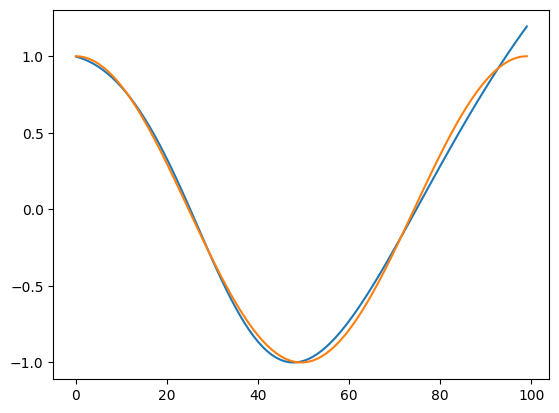

Epoch 8700, Loss: 0.0023189738858491182


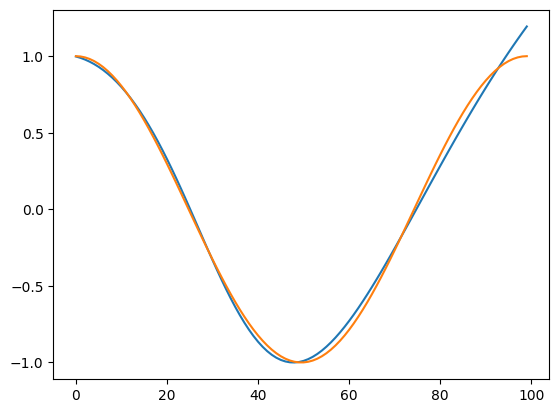

Epoch 8800, Loss: 0.002311242511495948


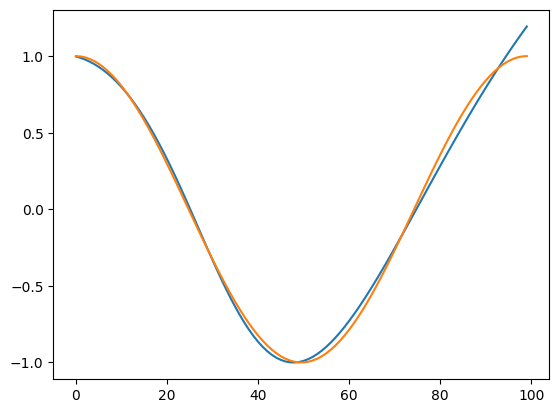

Epoch 8900, Loss: 0.002303547225892544


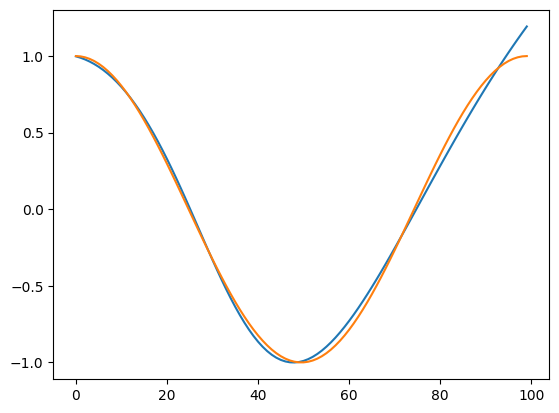

Epoch 9000, Loss: 0.0022958905901759863


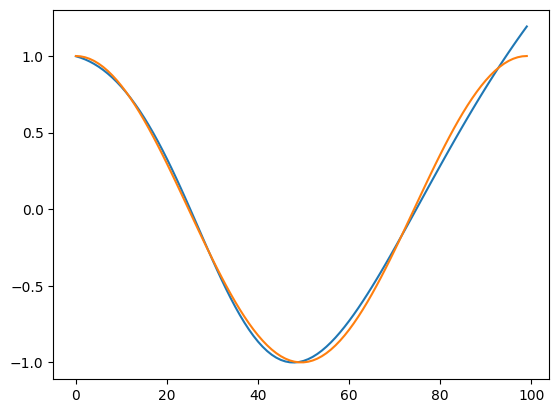

Epoch 9100, Loss: 0.0022882758639752865


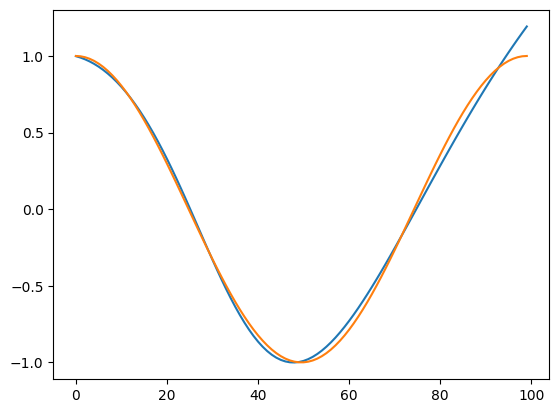

Epoch 9200, Loss: 0.0022807088680565357


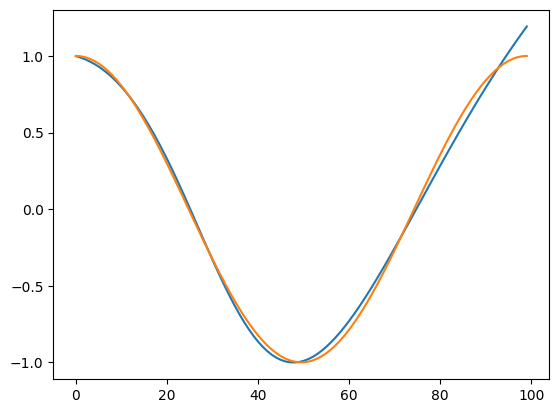

Epoch 9300, Loss: 0.0022731944918632507


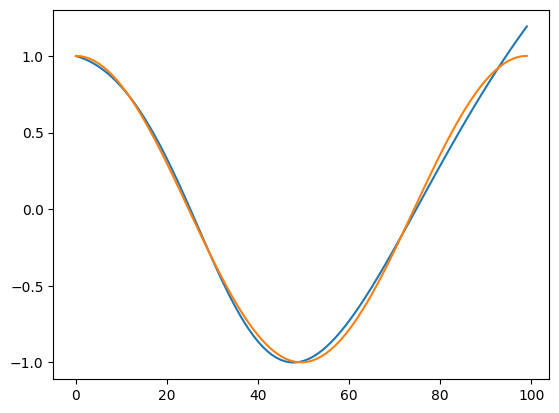

Epoch 9400, Loss: 0.0022657045628875494


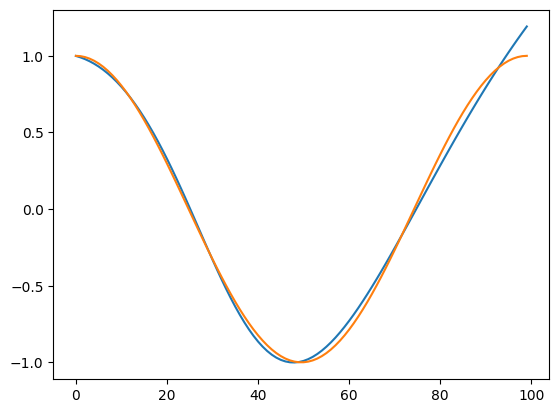

Epoch 9500, Loss: 0.0022582507226616144


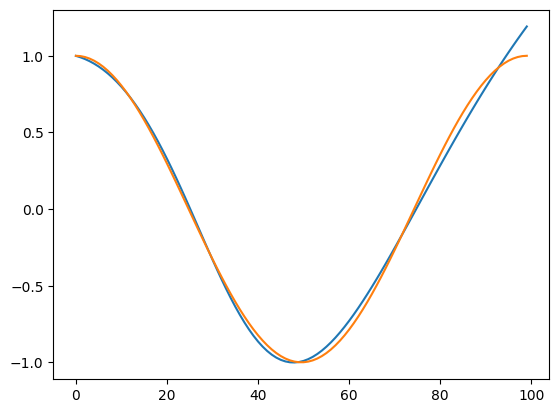

Epoch 9600, Loss: 0.0022508581168949604


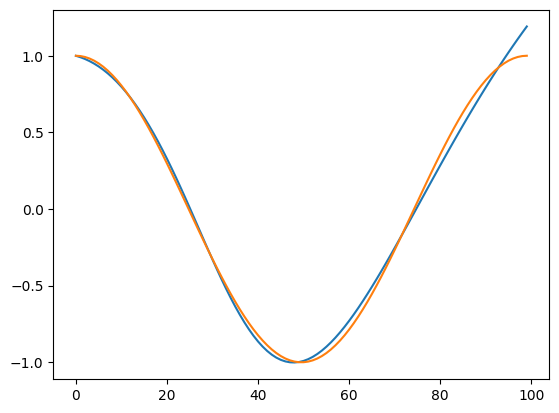

Epoch 9700, Loss: 0.0022435018327087164


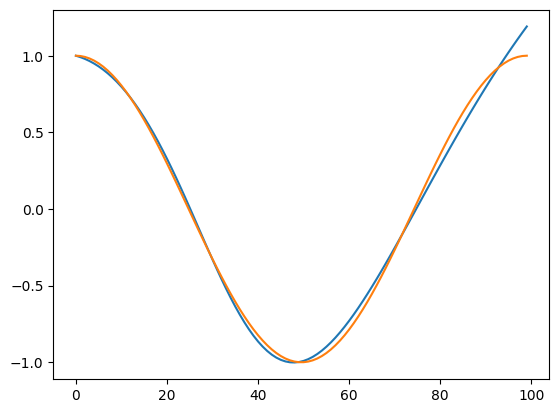

Epoch 9800, Loss: 0.0022361709270626307


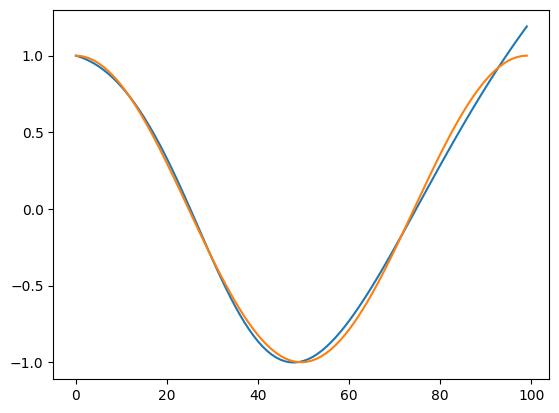

Epoch 9900, Loss: 0.0022288926411420107


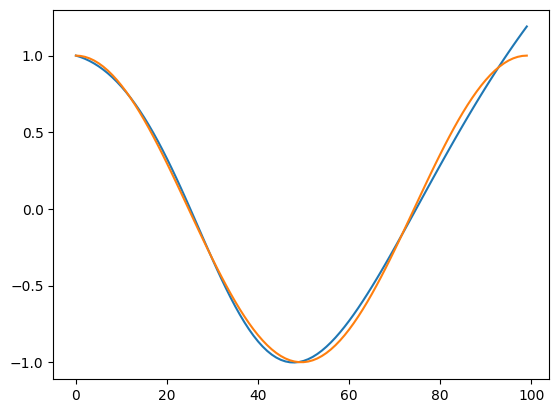

In [91]:
import math
prev_loss = math.inf

# Training loop
learning_rate = 0.01
num_epochs = 10000

ADAGRAD = True

for epoch in range(num_epochs):
    # Compute gradients and update parameters
    grads = grad_loss(params, X, y)

    if ADAGRAD:
        params = [param - learning_rate * grad_param  for param, grad_param in zip(params, grads)]
    else:
        mems = [ 0.99*mem + grad**2 for mem, grad in zip(mems, grads)]
        params = [param - learning_rate * grad_param / jnp.sqrt( mem + 1e-8) for param, grad_param, mem in zip(params, grads, mems)]
    
    # Print the loss every 100 epochs
    
    loss_value = mean_squared_error(params, x, sin)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value}")
        plt.plot(neural_network(params, x))
        plt.plot(sin)
        plt.show()
        
    if loss_value > prev_loss + 0.1:
        print(f"gradient descent ends")
        break
    prev_loss = loss_value
    


### Learning the actual circle

When we want to learn circle, then we actuall have to learn sinus and cosinus function at the same time, using the same structure of the hidden space.

In [146]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import math

class SimpleNN:
    def __init__(self, Din, Dout, hidden_size=12):
        # Set a random seed for reproducibility
        self.key = random.PRNGKey(0)
        self.key, self.subkey = random.split(self.key)
        self.input_dim = Din
        self.hidden_dim = hidden_size
        self.output_dim = Dout
        self.params = [
            random.normal(self.subkey, (self.input_dim, self.hidden_dim)),  random.normal(self.subkey, (self.hidden_dim,)),
            random.normal(self.subkey, (self.hidden_dim, self.output_dim)),  random.normal(self.subkey, (self.output_dim,)),
        ]
        self.mems = [ jnp.zeros_like(param) for param in self.params]
        self.prev_loss = math.inf

    # Define the neural network model
    def neural_network(self, params, x):
        w1, b1, w2, b2 = params
        h = jnp.tanh(jnp.dot(x, w1) + b1)
        return jnp.dot(h, w2) + b2

    def predict(self, x):
      return self.neural_network(self.params, x)

    # Define the mean squared error loss function
    def mean_squared_error(self, params, x, y_true):
        y_pred = self.neural_network(params, x)
        return jnp.mean((y_pred - y_true)**2)

    # Initialize the neural network parameters
    def fit(self, X, Y, num_epochs, learning_rate):
        for epoch in range(num_epochs):
            #random subset of indices makes is a stochastic gradient descent
            random_indices = np.random.choice(len(X), min(len(X),256), replace=False)

            grads = grad(self.mean_squared_error)(self.params, X[random_indices], Y[random_indices])

            self.mems = [ 0.99*mem + grad**2 for mem, grad in zip(self.mems, grads)]
            self.params = [param - learning_rate * grad_param / jnp.sqrt( mem + 1e-8) for param, grad_param, mem in zip(self.params, grads, self.mems)]

            loss_value = self.mean_squared_error(self.params, X[random_indices], Y[random_indices])
            self.prev_loss = loss_value
            
            # Print the loss every 100 epochs
            if epoch % 100 == 0:
                loss_value = self.mean_squared_error(self.params, X, Y)
                print(f"\rEpoch {epoch},\tLoss: {loss_value}", end="")
        print()



In [97]:
X = points_interval
Y = points_circle

In [98]:
simpleNN = SimpleNN(2,2)

Epoch 0,	Loss: 2.7515249252319336


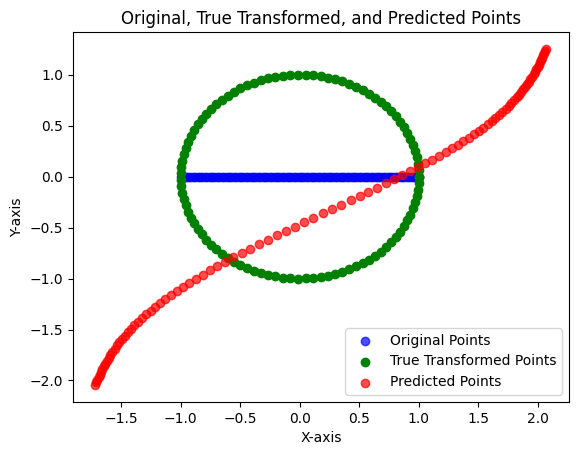

Epoch 0,	Loss: 2.586066722869873


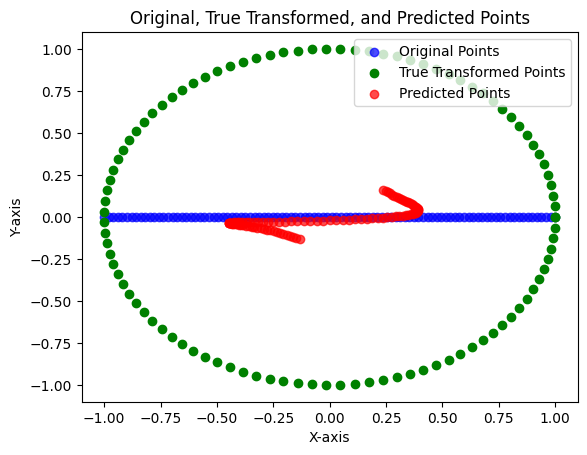

Epoch 0,	Loss: 0.5387478470802307


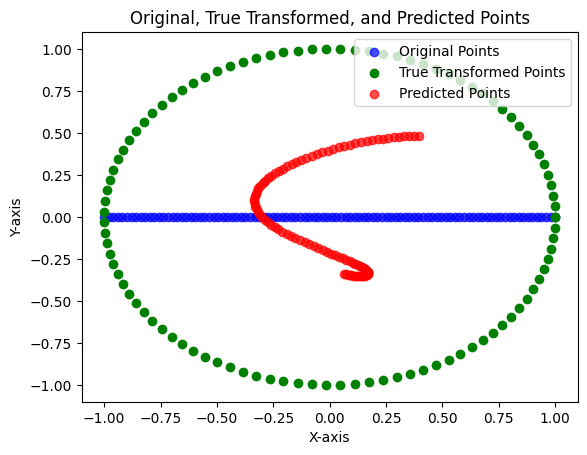

Epoch 0,	Loss: 0.27526628971099854


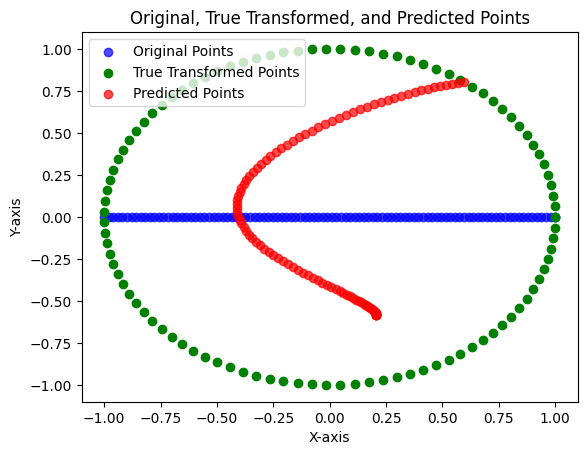

Epoch 0,	Loss: 0.19223515689373016


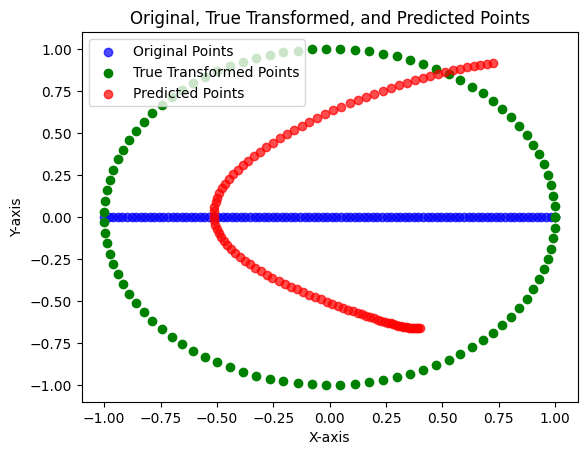

Epoch 0,	Loss: 0.14810413122177124


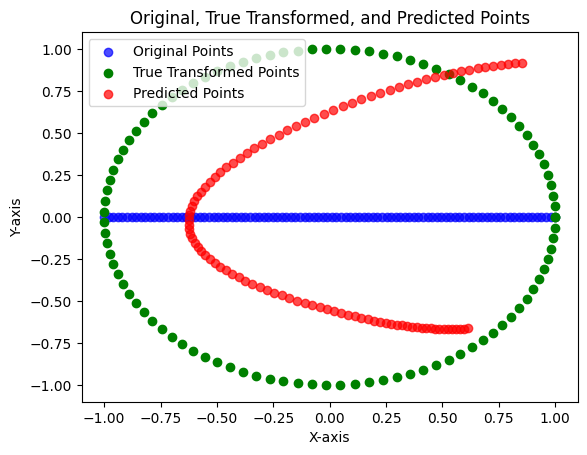

Epoch 0,	Loss: 0.11312425136566162


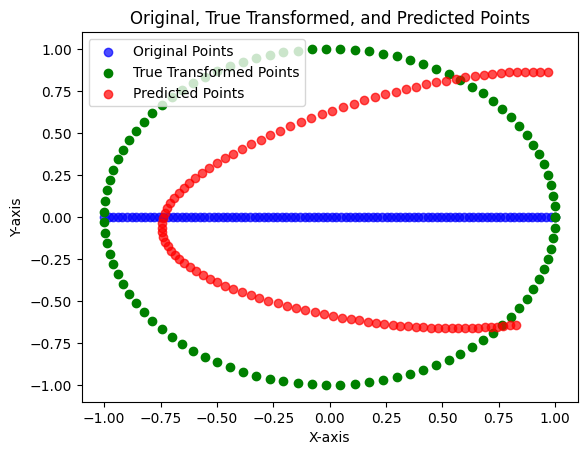

Epoch 0,	Loss: 0.0842246413230896


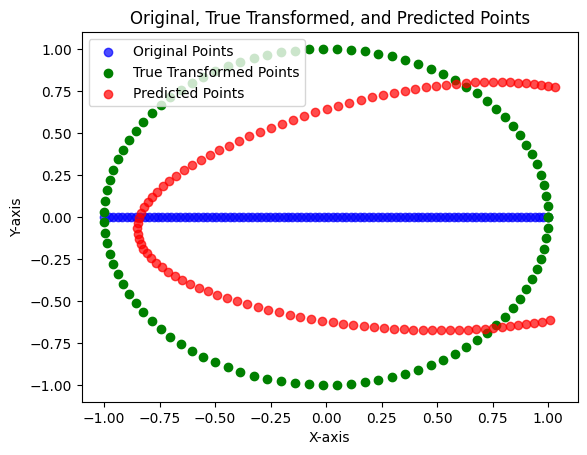

Epoch 0,	Loss: 0.062286827713251114


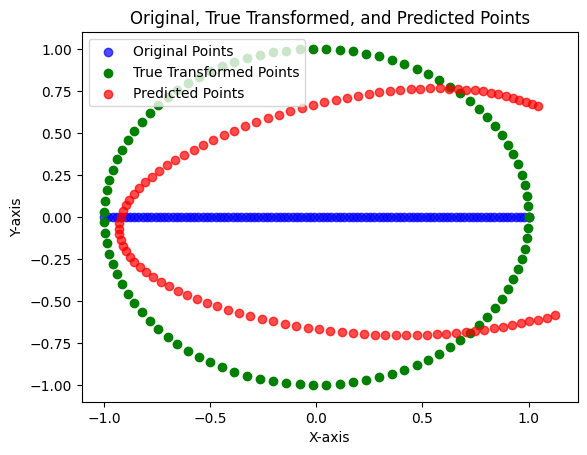

Epoch 0,	Loss: 0.04603038728237152


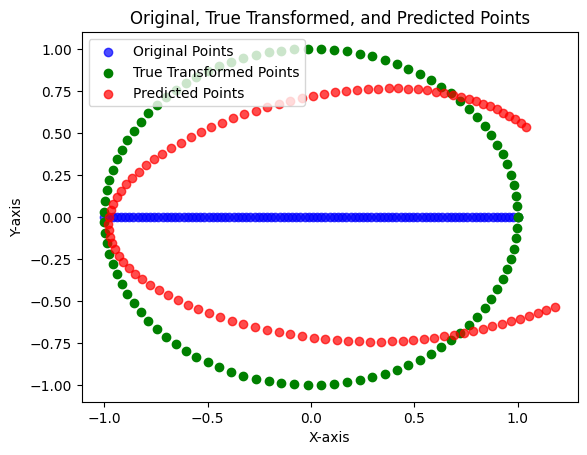

Epoch 0,	Loss: 0.03275526314973831


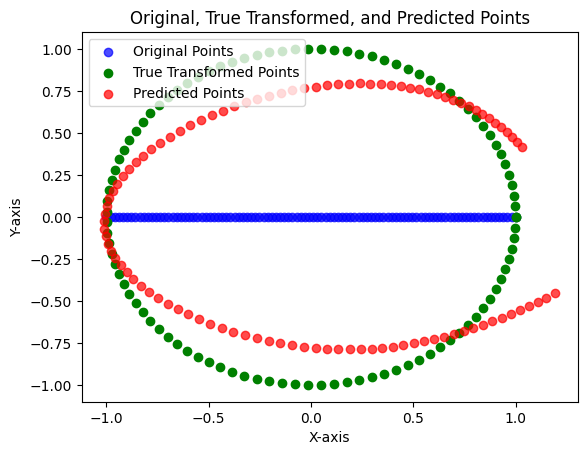

Epoch 0,	Loss: 0.020917706191539764


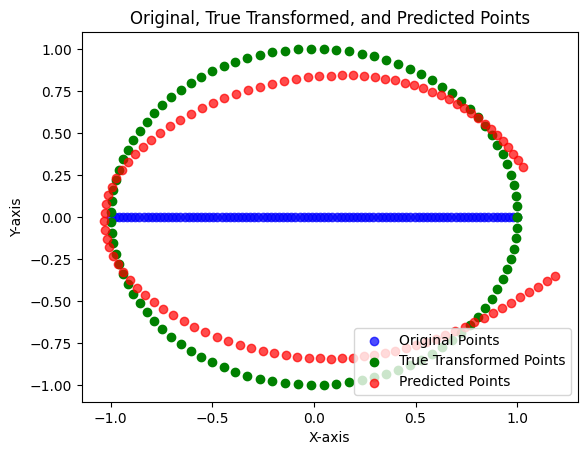

Epoch 0,	Loss: 0.011166493408381939


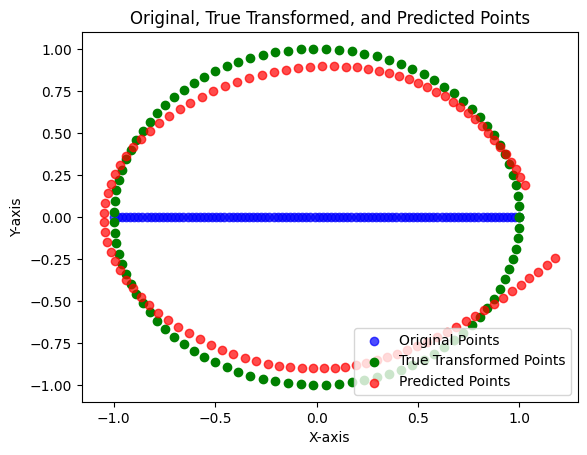

Epoch 0,	Loss: 0.0049704015254974365


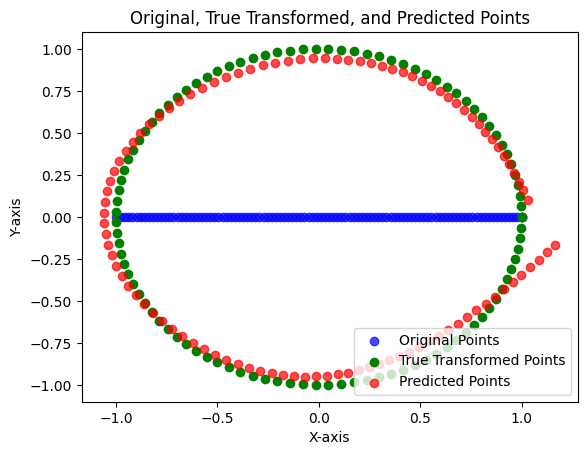

Epoch 0,	Loss: 0.0023454148322343826


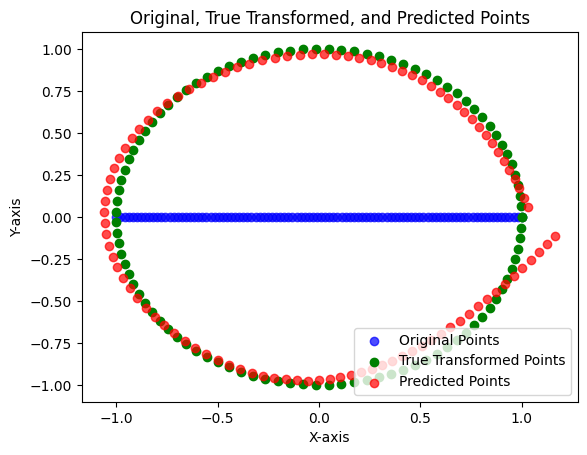

Epoch 0,	Loss: 0.0016524243401363492


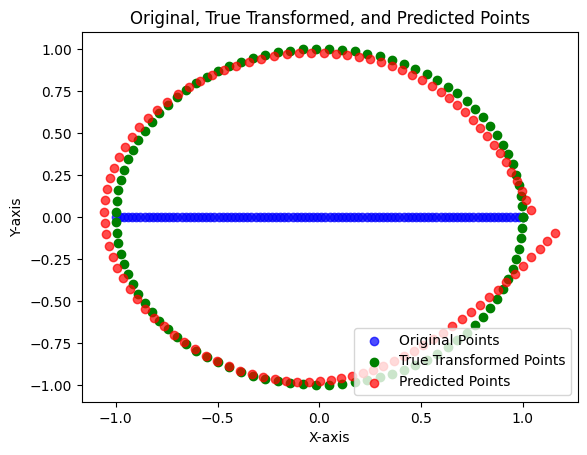

Epoch 0,	Loss: 0.0014678590232506394


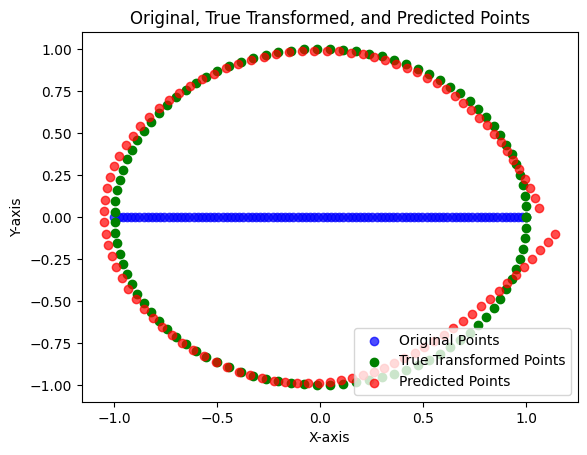

Epoch 0,	Loss: 0.0013481074711307883


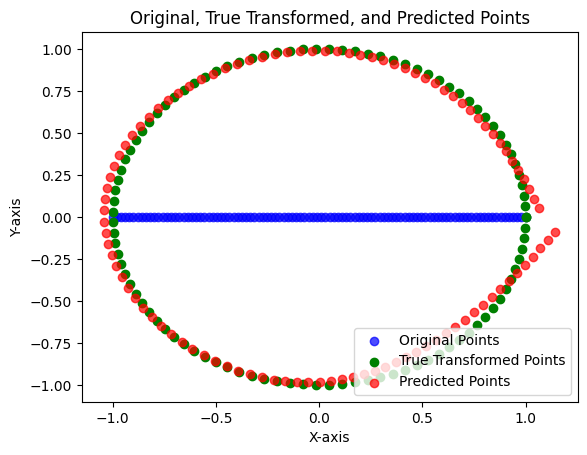

Epoch 0,	Loss: 0.001220434671267867


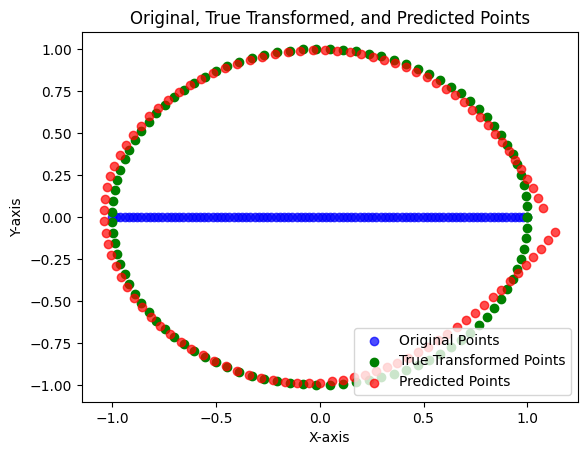

Epoch 0,	Loss: 0.0011483816197142005


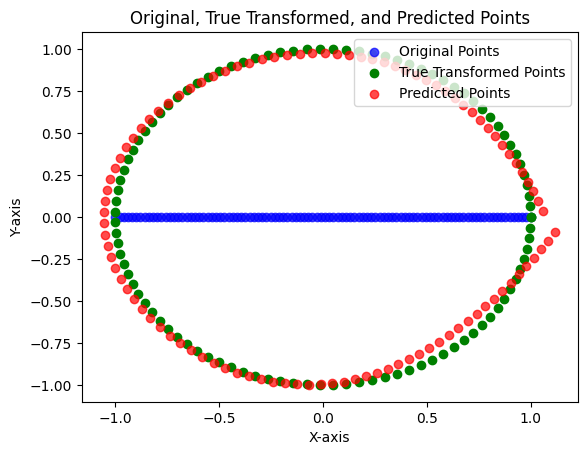

Epoch 0,	Loss: 0.0011392084416002035


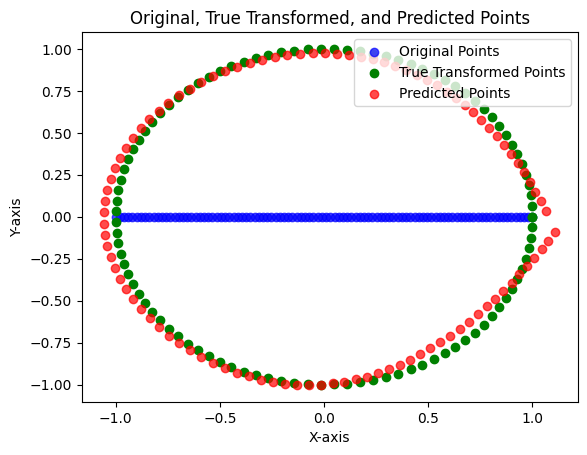

Epoch 0,	Loss: 0.001135990140028298


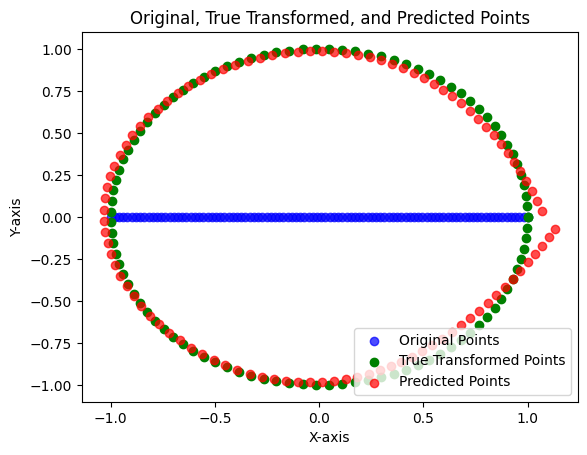

Epoch 0,	Loss: 0.0009943009354174137


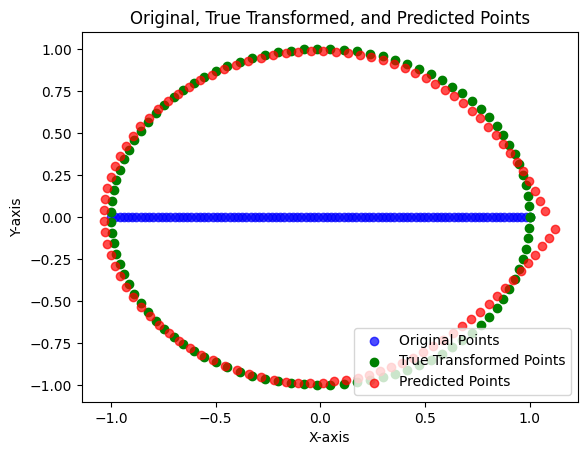

Epoch 0,	Loss: 0.0008996260003186762


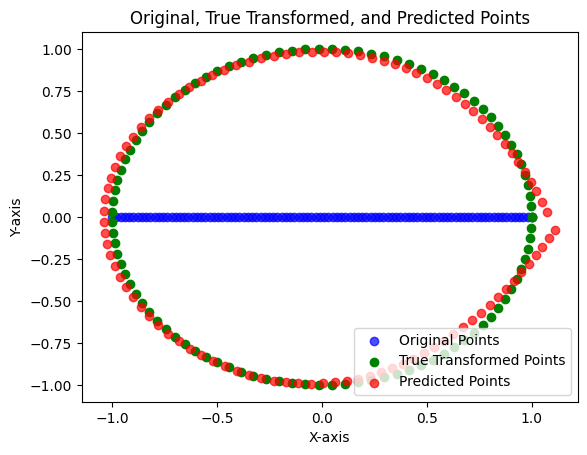

Epoch 0,	Loss: 0.0008453978225588799


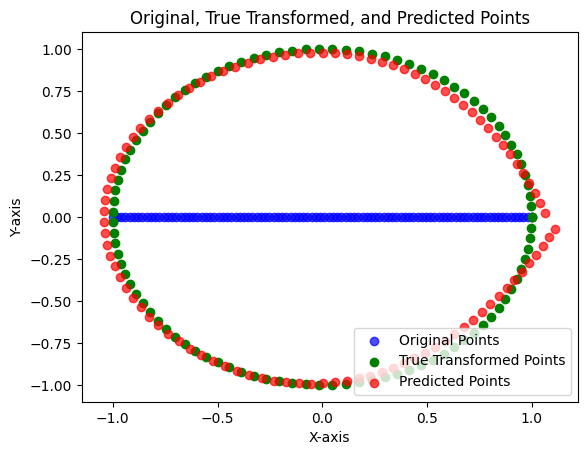

Epoch 0,	Loss: 0.0008455856004729867


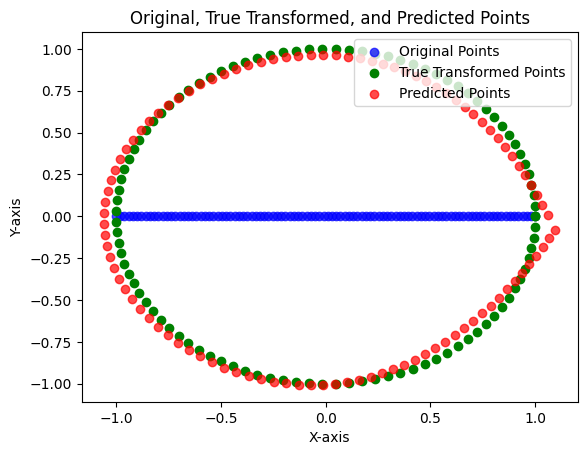

Epoch 0,	Loss: 0.0011038202792406082


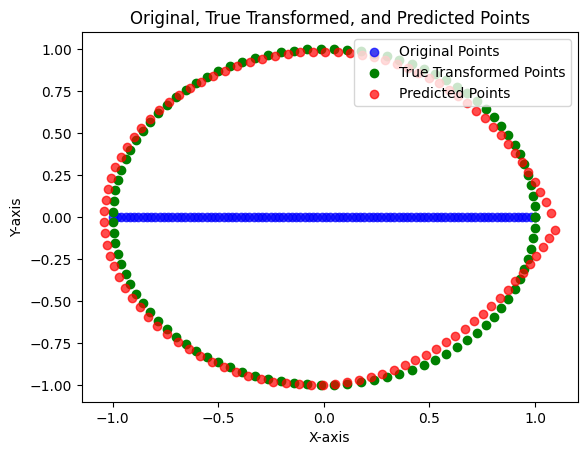

Epoch 0,	Loss: 0.000777450914029032


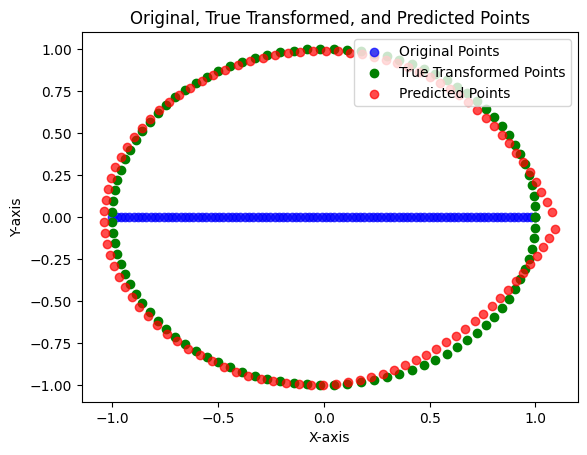

Epoch 0,	Loss: 0.0007394248968921602


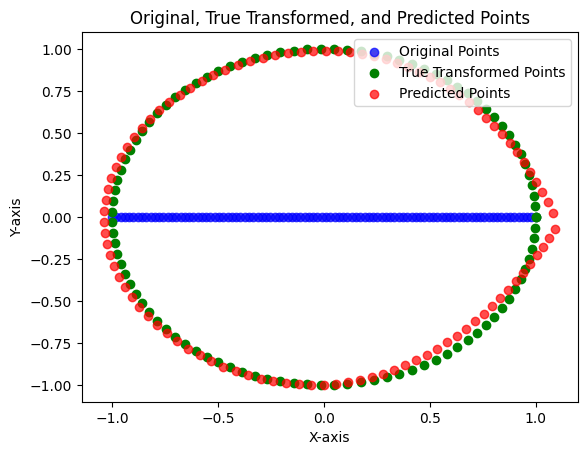

Epoch 0,	Loss: 0.0007097394554875791


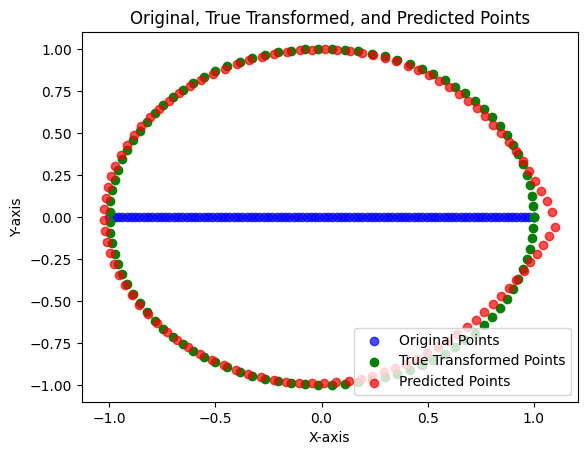

In [99]:
for i in range(30):
    if i == 0:
        #this is just to see how the training beggins
        simpleNN.fit(X, Y, num_epochs=1, learning_rate=0.01)
    else:
        simpleNN.fit(X, Y, num_epochs=100, learning_rate=0.01)
    
    # After training, use the learned model to predict the transformed points
    Y_learnt = simpleNN.predict(X)
    
    # Plot the original points, the true transformed points, and the predicted points
    plt.scatter(X[:, 0], X[:, 1], label='Original Points', c='blue', alpha=0.7)
    plt.scatter(Y[:, 0], Y[:, 1], label='True Transformed Points', c='green')
    plt.scatter(Y_learnt[:, 0], Y_learnt[:, 1], label='Predicted Points', c='red', alpha=0.7)
    
    plt.title('Original, True Transformed, and Predicted Points')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.show()

# Learning identity function aka AutoEncoder

You've already seen t-SNE on MNIST, which miraculously learns a 2D representation of the MNIST digits. Still, have a look again:

In [108]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.manifold import TSNE


DIGIT = 0



# Step 1: Download MNIST dataset
mnist = datasets.fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target.astype(int)

# Step 2: Select only digits representing DIGIT
X_ones = X[y == DIGIT]

# Step 3: Take a subset of 100
subset_size = 1000
X_subset = X_ones[:subset_size]

# Step 4: Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_subset)



/Users/marek-ext/MOJE/ml_uwr_23/.ml_venv/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


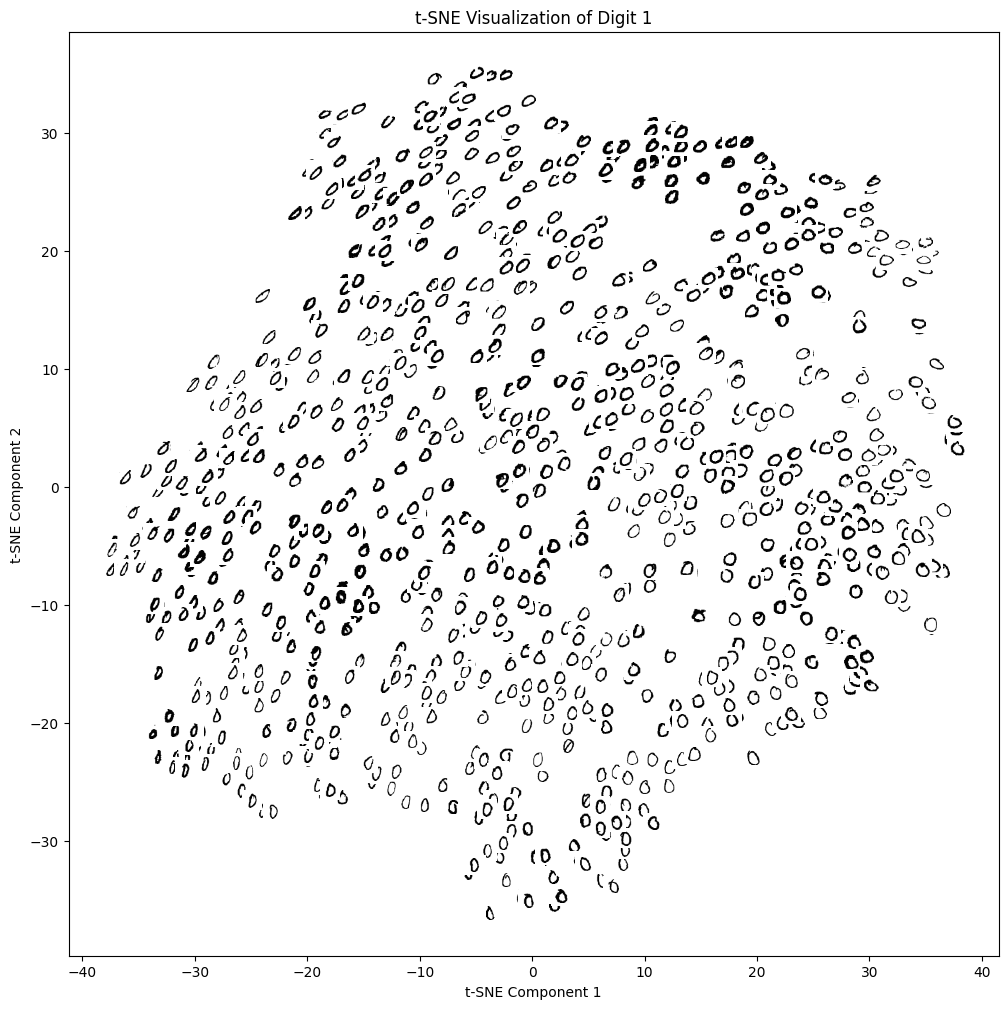

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn import datasets
from sklearn.manifold import TSNE


# Step 5: Scatterplot with digit markers
fig, ax = plt.subplots(figsize=(12, 12))
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1])

# Annotate a few points with their digit images
for i in range(0, subset_size, 1):  # Adjust the step for more/less images
    digit_image = X_subset.to_numpy()[i].reshape(28, 28)
    imagebox = OffsetImage(digit_image, zoom=0.5, cmap='binary')
    ab = AnnotationBbox(imagebox, (X_tsne[i, 0], X_tsne[i, 1]), frameon=False)
    ax.add_artist(ab)

ax.set_title('t-SNE Visualization of Digit 1')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')

plt.show()

t-SNE is a beautiful algorithm with a deep probabilistic reasoning underneath. However, you can obtain equally non trivial 2D representation with the methods you were presented above. The whole idea is to learn the identity function. The catch is that we need to learn identity function from a dimension of size 784 into the same dimension. If we impose restrictions on the actual neural network that will represent this 784-dimensional identity, then if the hidden space is only 2D, we will get the below:

In [117]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms

# Autoencoder Class
class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = nn.Linear(28 * 28, 2)  # Encode down to 2 features
        self.decoder = nn.Linear(2, 28 * 28)  # Decode back to original image size

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image
        encoded = torch.sigmoid(self.encoder(x))
        decoded = torch.sigmoid(self.decoder(encoded))
        return decoded

    def encode(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image
        encoded = torch.sigmoid(self.encoder(x))
        return encoded

    def decode(self, x):
        x = x.view(-1, 2)  # Flatten the image
        encoded = torch.sigmoid(self.decoder(x))
        return encoded



In [118]:

# Load and preprocess MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Filter for only digit '1' and convert to numpy arrays
mnist_data = [(np.array(data[0]), data[1]) for data in mnist_dataset if data[1] == DIGIT]

# Convert to numpy arrays
train_images = np.array([data[0] for data in mnist_data])

# Convert numpy arrays to PyTorch tensors
train_images = torch.Tensor(train_images)


In [119]:

# Instantiate the model
model = SimpleAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [120]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Training Loop
epochs = 1000
batch_size = 100
for epoch in range(epochs):
    for i in range(0, len(train_images), batch_size):
        batch_data = train_images[i:i+batch_size]
        optimizer.zero_grad()
        output = model(batch_data)
        loss = criterion(output, batch_data.view(-1, 28*28))  # Compare output with input
        loss.backward()
        optimizer.step()
    print(f'\rEpoch {epoch+1},\t Loss: {loss.item()}', end="")
    if epoch% 100 == 0:
        print()
        #discriminate
        X_tru = train_images.detach().numpy().reshape(-1,784)
        X_enc = model(train_images).detach().numpy()
        X = np.vstack([X_tru, X_enc])
        y = np.array(len(X_tru)*[1] + len(X_enc)*[0])

        # Split the dataset into a training set and a test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # Create kNN classifier. You can adjust the number of neighbors (n_neighbors)
        knn = KNeighborsClassifier(n_neighbors=3)
        
        # Train the classifier
        knn.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = knn.predict(X_test)
        
        # Calculate the accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy of the discriminator: {accuracy * 100:.2f}%")
        
        # Add testing and visualization of results as required.


Epoch 1,	 Loss: 0.22325953841209412
Accuracy of the discriminator: 100.00%
Epoch 101,	 Loss: 0.059801299124956134
Accuracy of the discriminator: 99.94%
Epoch 201,	 Loss: 0.047624256461858754
Accuracy of the discriminator: 98.79%
Epoch 301,	 Loss: 0.044001240283250816
Accuracy of the discriminator: 97.86%
Epoch 401,	 Loss: 0.043311994522809984
Accuracy of the discriminator: 97.05%
Epoch 501,	 Loss: 0.043255202472209934
Accuracy of the discriminator: 96.74%
Epoch 601,	 Loss: 0.043246679008007055
Accuracy of the discriminator: 96.57%
Epoch 701,	 Loss: 0.043227177113294634
Accuracy of the discriminator: 96.26%
Epoch 801,	 Loss: 0.043202970176935196
Accuracy of the discriminator: 96.15%
Epoch 901,	 Loss: 0.043180502951145175
Accuracy of the discriminator: 95.98%
Epoch 1000,	 Loss: 0.04316207394003868

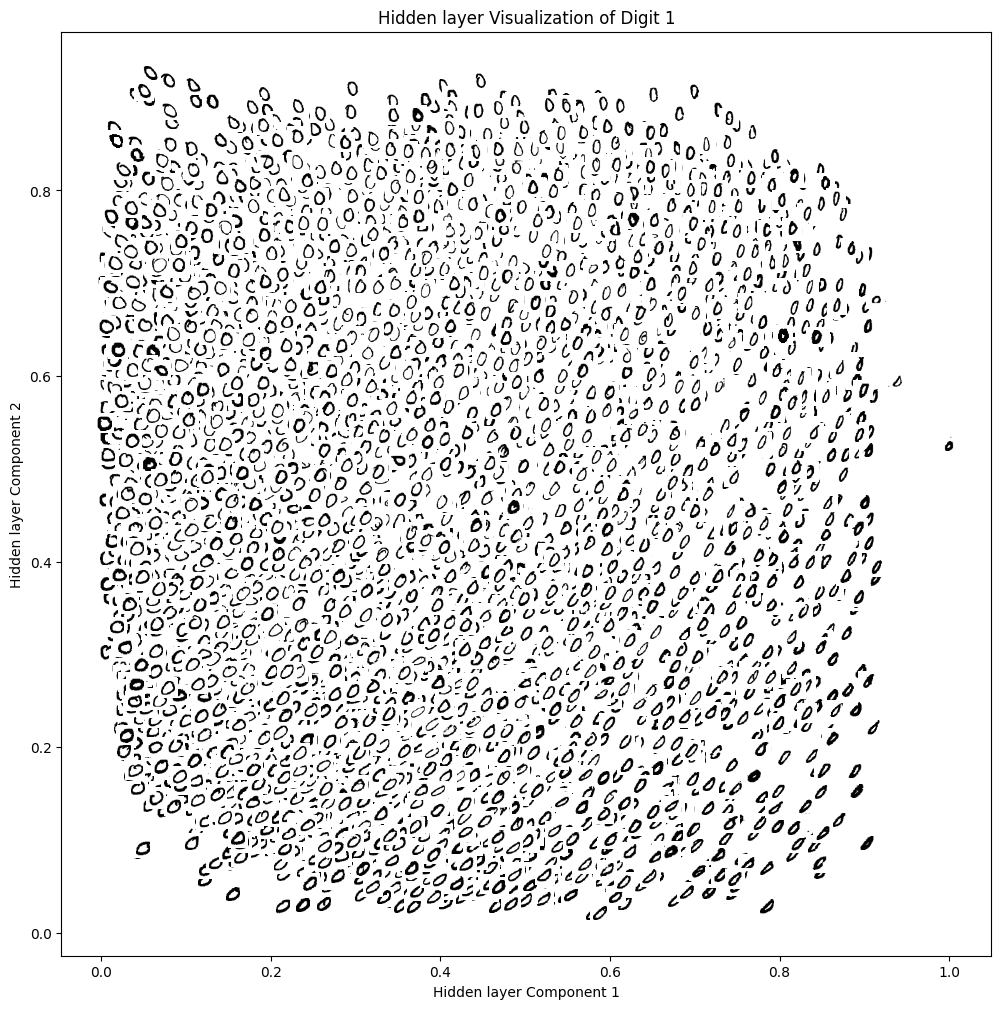

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn import datasets
from sklearn.manifold import TSNE

X_images = train_images.clone().detach().numpy().reshape(-1, 28,28)
X_embedd = model.encode(train_images).clone().detach().numpy()

show_frac = 1

# Step 5: Scatterplot with digit markers
fig, ax = plt.subplots(figsize=(12, 12))
scatter = ax.scatter(X_embedd[::show_frac, 0], X_embedd[::show_frac, 1])

# Annotate a few points with their digit images
for i in range(0, X_images.shape[0], show_frac):  # Adjust the step for more/less images
    digit_image = X_images[i].reshape(28, 28)
    imagebox = OffsetImage(digit_image, zoom=0.5, cmap='binary')
    ab = AnnotationBbox(imagebox, (X_embedd[i, 0], X_embedd[i, 1]), frameon=False)
    ax.add_artist(ab)

ax.set_title('Hidden layer Visualization of Digit 1')
ax.set_xlabel('Hidden layer Component 1')
ax.set_ylabel('Hidden layer Component 2')

plt.show()

In [122]:

# Define the range and number of points for each dimension
x_start, x_end, num_points = 0, 1, 50  # For x-axis
y_start, y_end = 0, 1  # For y-axis (using the same num_points)

# Create linspace for each dimension
x = np.linspace(x_start, x_end, num_points)
y = np.linspace(y_start, y_end, num_points)

# Create a meshgrid
xx, yy = np.meshgrid(x, y)


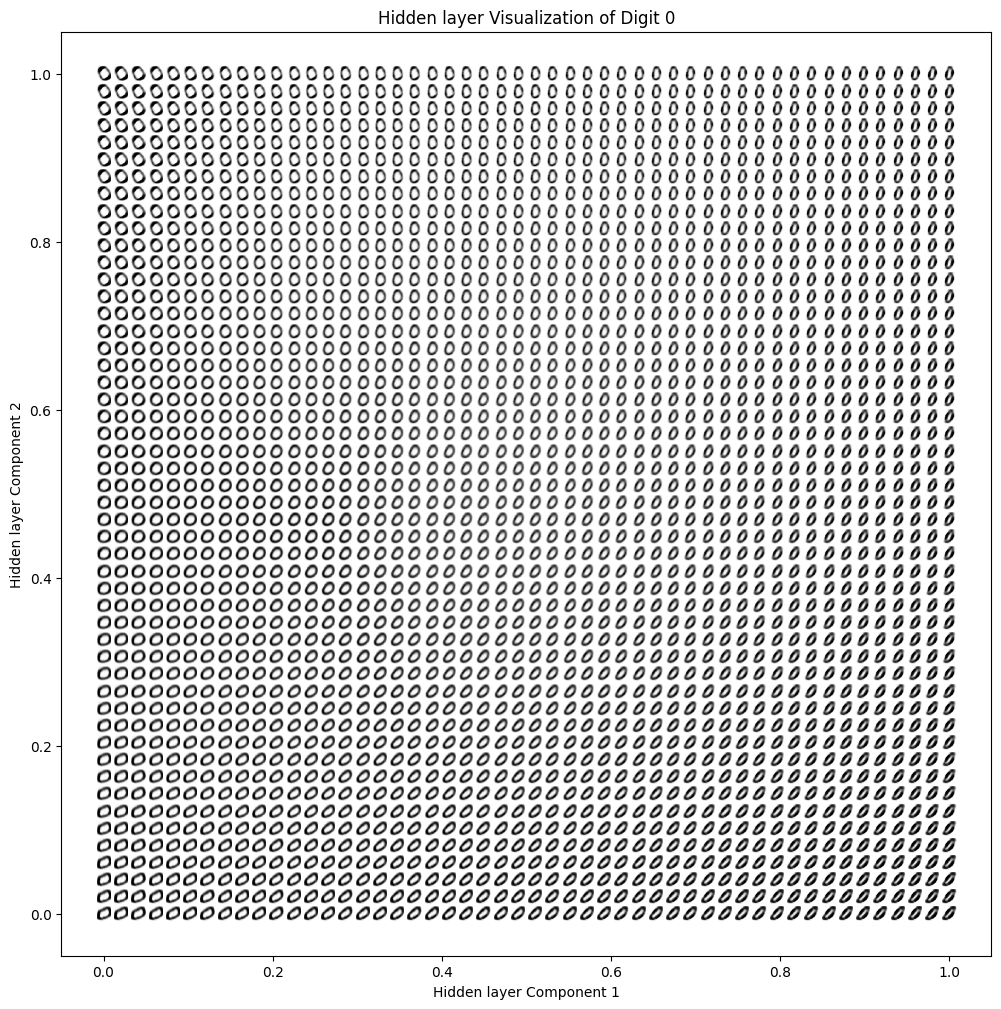

In [123]:
#generated images
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn import datasets
from sklearn.manifold import TSNE

X_embedd = torch.Tensor(np.hstack([xx.reshape(-1,1), yy.reshape(-1,1)]))

X_gener = model.decode(X_embedd).clone().detach().numpy().reshape(-1, 28,28)

show_frac = 1

# Step 5: Scatterplot with digit markers
fig, ax = plt.subplots(figsize=(12, 12))
scatter = ax.scatter(X_embedd[::show_frac, 0], X_embedd[::show_frac, 1])

# Annotate a few points with their digit images
for i in range(0, X_embedd.shape[0], show_frac):  # Adjust the step for more/less images
    digit_image = X_gener[i].reshape(28, 28)
    imagebox = OffsetImage(digit_image, zoom=0.5, cmap='binary')
    ab = AnnotationBbox(imagebox, (X_embedd[i, 0], X_embedd[i, 1]), frameon=False)
    ax.add_artist(ab)

ax.set_title(f"Hidden layer Visualization of Digit {DIGIT}")
ax.set_xlabel('Hidden layer Component 1')
ax.set_ylabel('Hidden layer Component 2')

plt.show()

## Your first generative model using t-SNE

In [152]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

DIGIT = 1


# 1. Download MNIST
mnist = tf.keras.datasets.mnist
(x_train, y_train), _ = mnist.load_data()

Let's do t-SNE with only 1 dimension:

In [153]:


# 2. Select only 0 digits
digit_indices = np.where(y_train == DIGIT)[0]
digit_images = x_train[digit_indices]

# 3. Run TSNE with dimension 1
tsne = TSNE(n_components=1, random_state=0)
digit_images_flat = digit_images.reshape(len(digit_images), -1)
tsne_results = tsne.fit_transform(digit_images_flat)


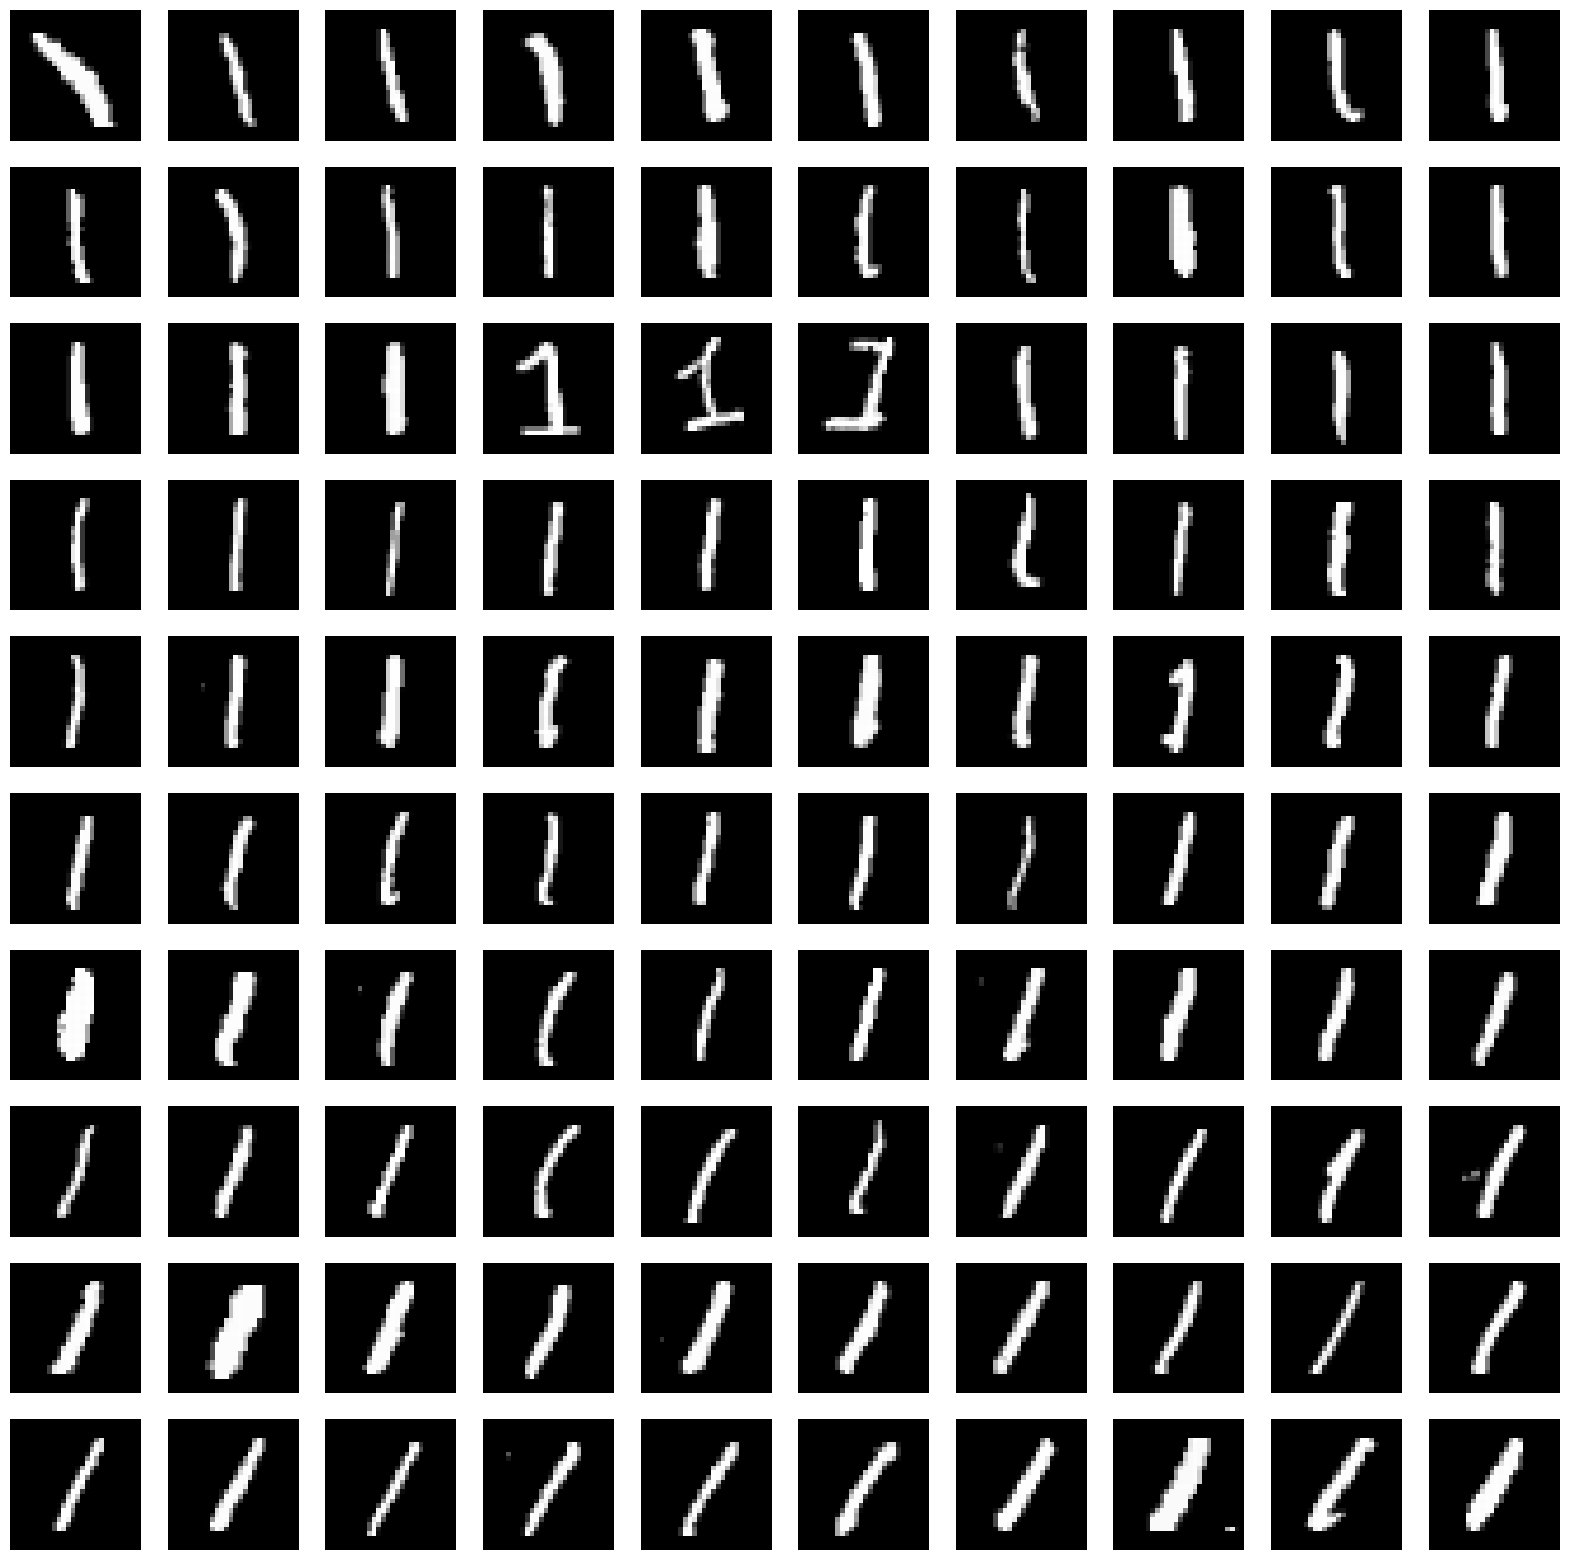

In [155]:


# Order images by TSNE value
ordered_indices = np.argsort(tsne_results, axis=0).flatten()
ordered_images = digit_images[ordered_indices]

subset_indices = list(range(0,6000,60))

# Plotting
plt.figure(figsize=(20, 20))
for i, image in enumerate(ordered_images[subset_indices]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.show()


We can see above that t-SNE has embedded MNIST images on a single line in a way that the top left images are skewed like \, while as the images go more to the right, then they are bent more like /. Below we shall learn this behavior by learning a function inverse to t-SNE. 

Note that the t-SNE transformation above was in fact a function from $\mathbb{R}^{784}$ to $\mathbb{R}^1$. Hence we want to learn (using a neural network) a function from $\mathbb{R}^1$ back to $\mathbb{R}^{784}$.

In [156]:
X = tsne_results[ordered_indices[0:6000]]
Y = digit_images[ordered_indices[0:6000]].reshape(-1,784)


In [157]:
X = (X-X.mean())/X.std() * 10
X

array([[-18.37877 ],
       [-18.37875 ],
       [-18.372051],
       ...,
       [ 17.56309 ],
       [ 17.587393],
       [ 17.595434]], dtype=float32)

In [158]:
X.shape, Y.shape

((6000, 1), (6000, 784))

In [159]:
simpleNN = SimpleNN(1,784, hidden_size=200)


In [160]:
simpleNN.fit(X, Y, num_epochs=10000, learning_rate=0.1)

Epoch 9900,	Loss: 633.9035644531255


In [161]:
Y_learnt = simpleNN.predict(X)

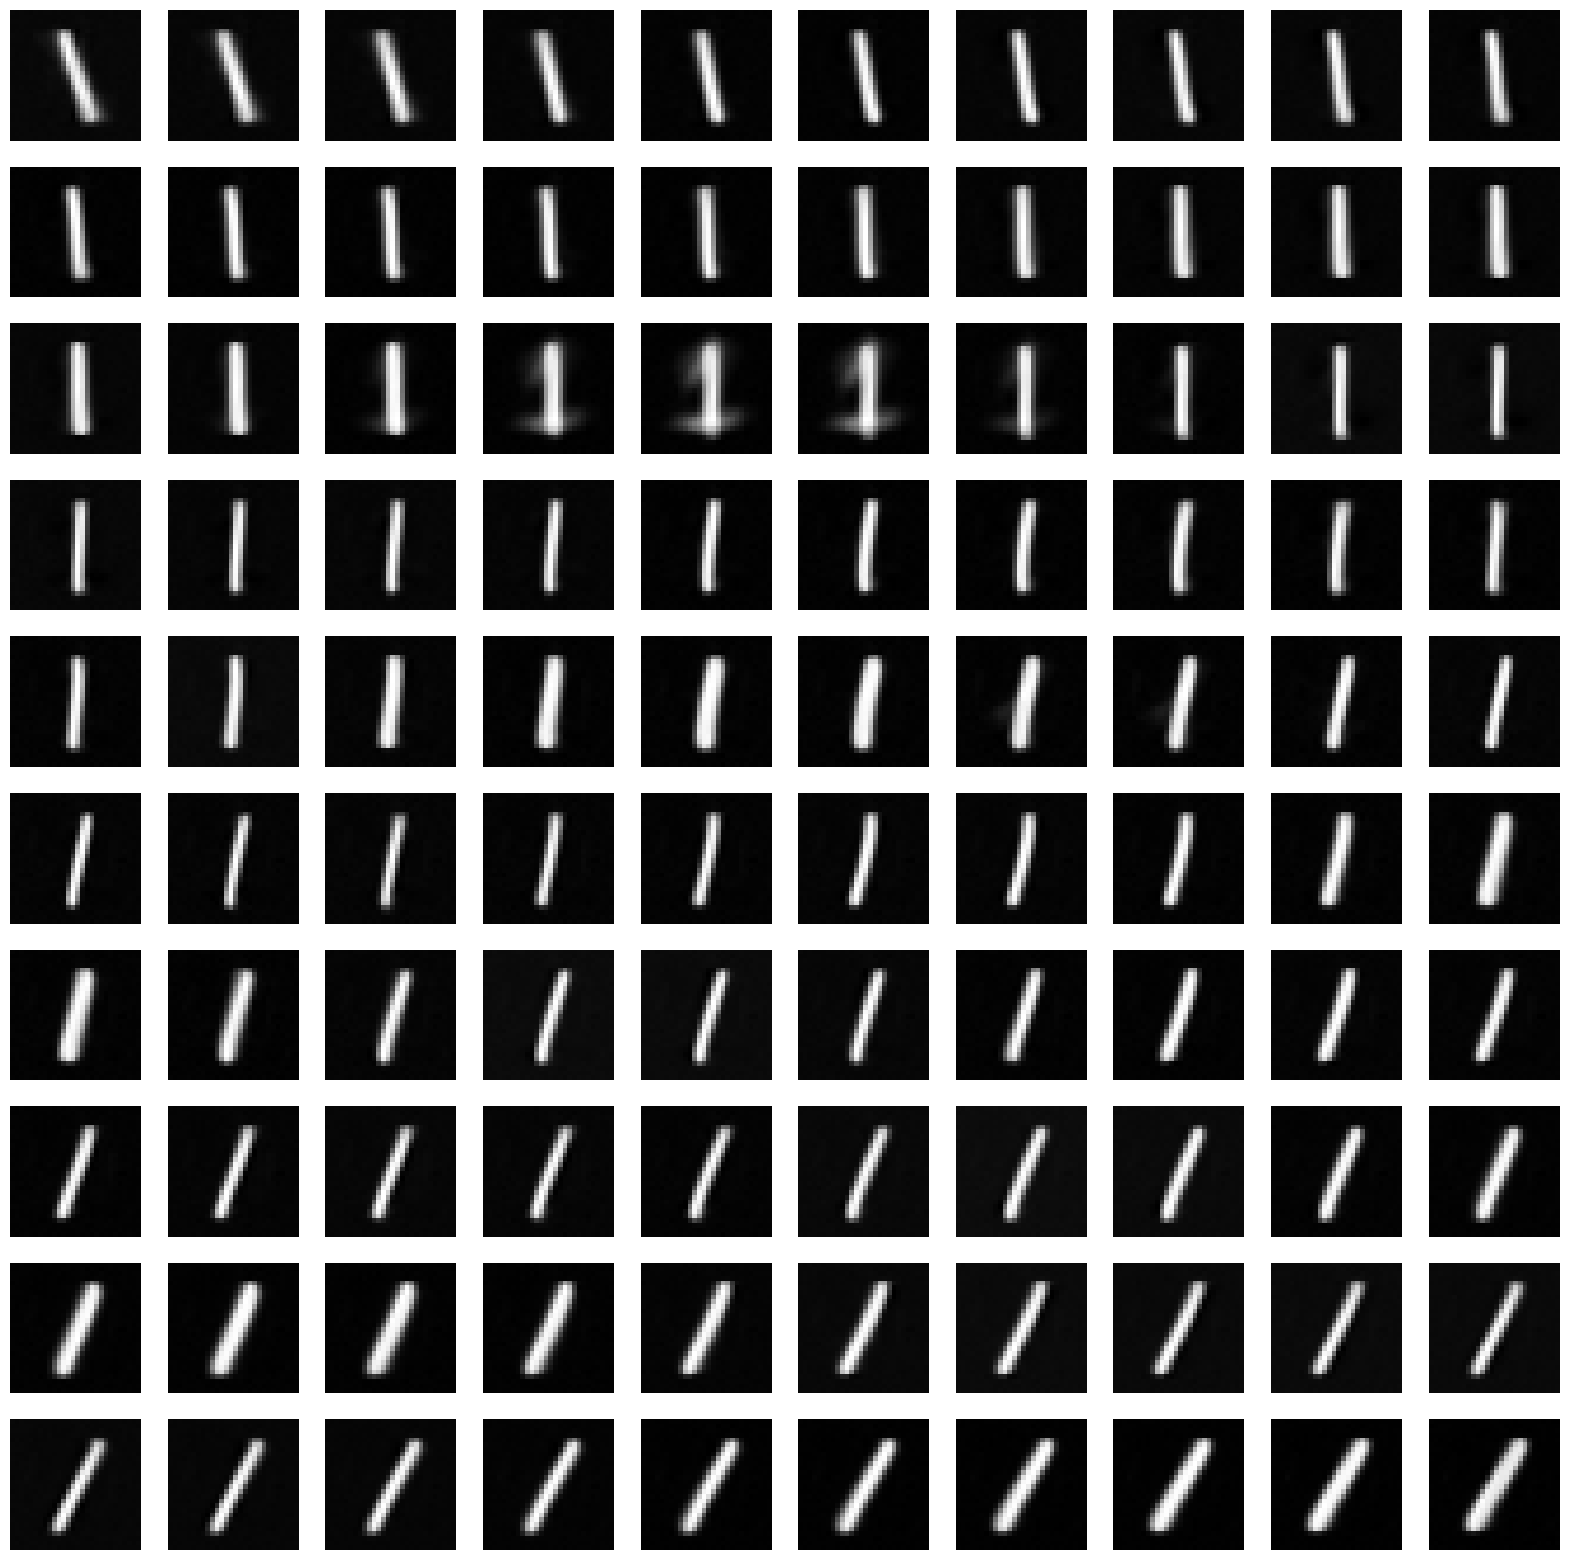

In [162]:
# Plotting
plt.figure(figsize=(20, 20))
for i, image in enumerate(Y_learnt[::60]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(image.reshape(28,28), cmap='gray')
    plt.axis('off')
plt.show()

The above images were reconstructions of the original images. However the below ones are totally artificially generated.

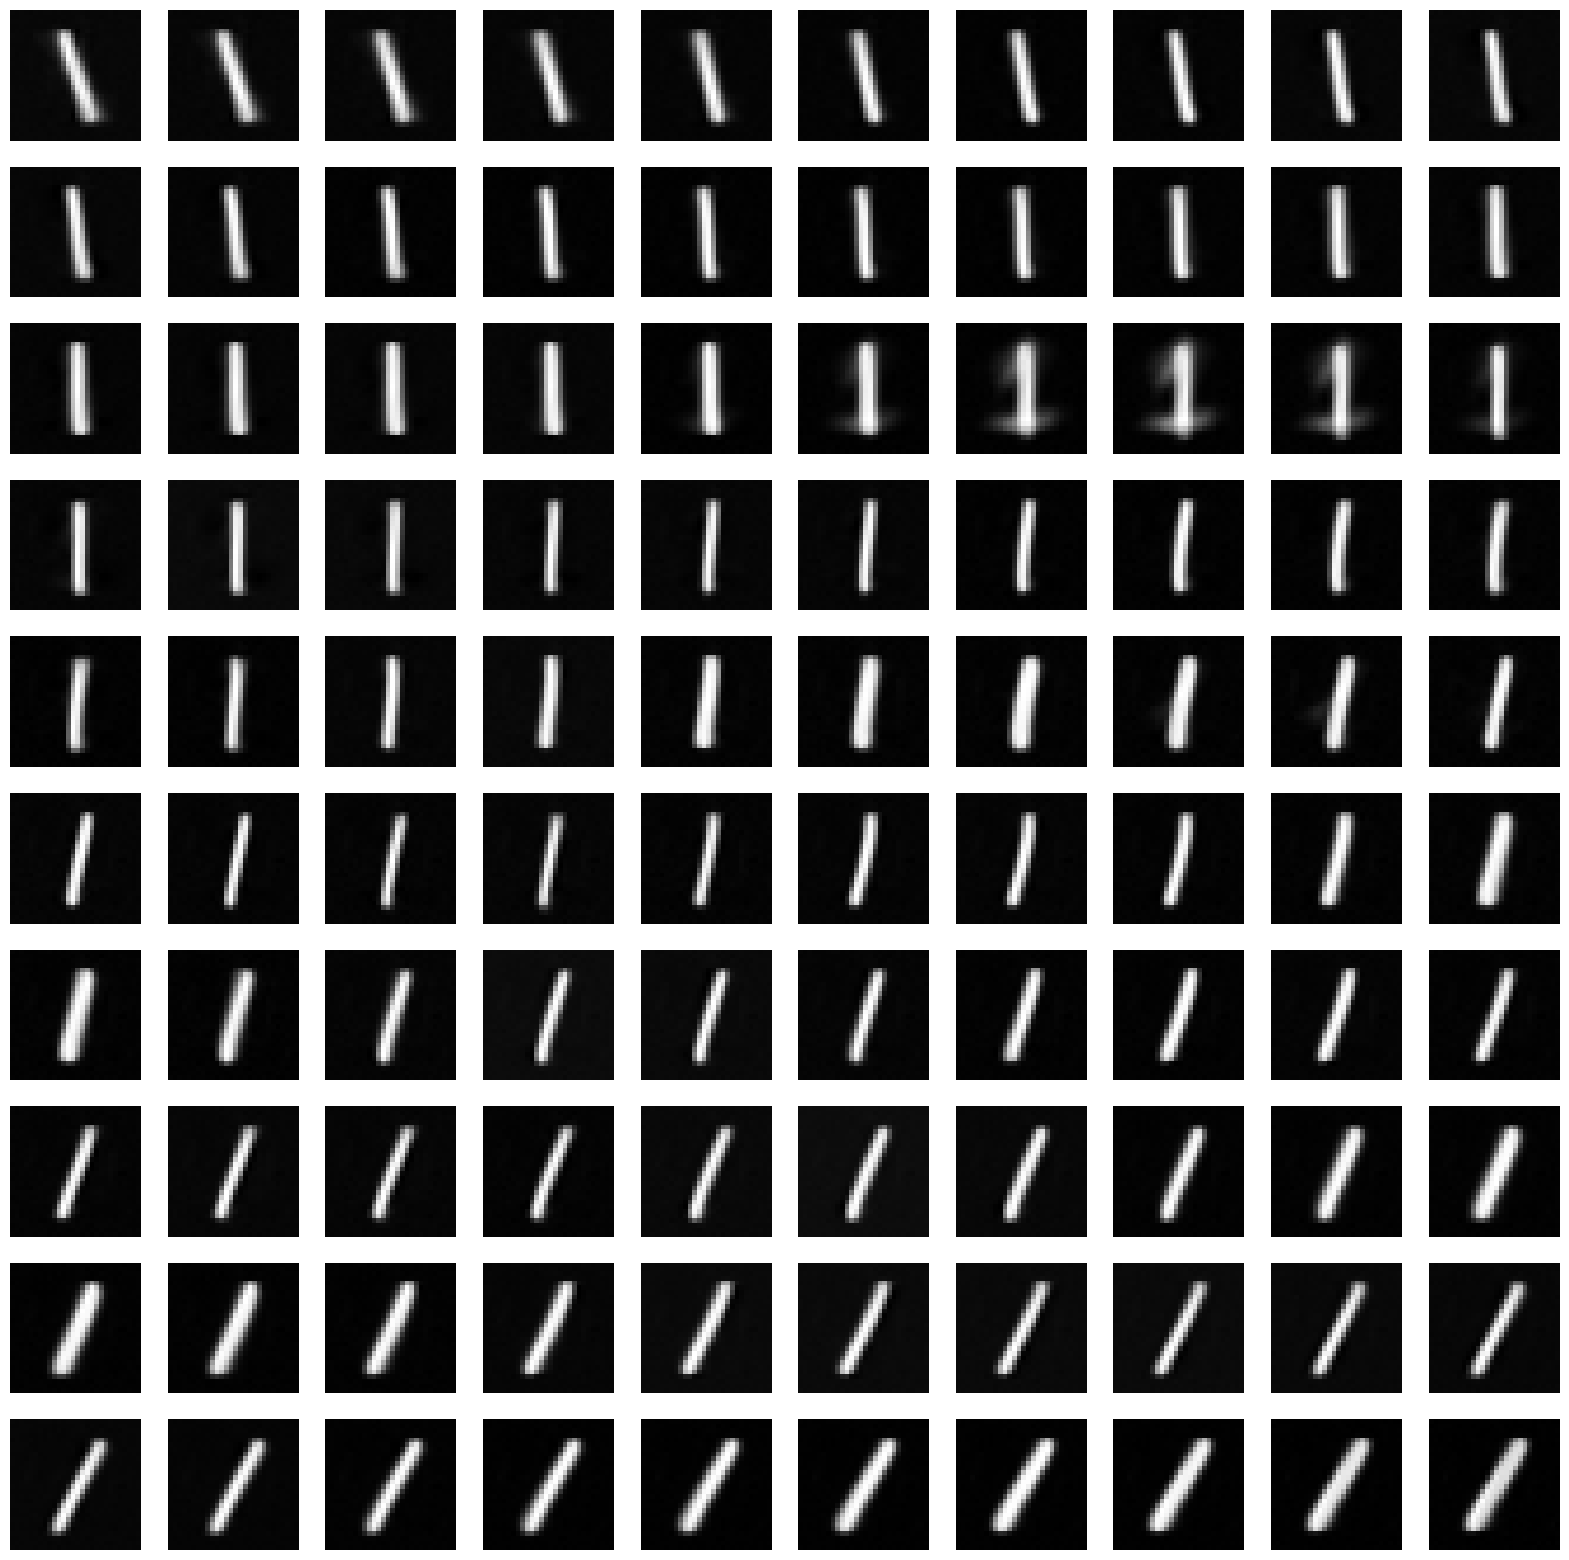

In [163]:
# Plotting
plt.figure(figsize=(20, 20))
for i, D1val in enumerate(np.linspace(X[0], X[-1], 100)):
    plt.subplot(10, 10, i + 1)
    plt.imshow(simpleNN.predict(D1val).reshape(28,28), cmap='gray')
    plt.axis('off')
plt.show()

We can see that the artificially generated images on one side nicely capture the high level features of the digits from the mnist dataset. On the other hand however their quality ain't as sharp as in the original MNIST.

Hence, a question arises: how we can numerically assess the quality of this generation?
Below we can see a very simple approach: we can create classifier that will learn to distinguish between the original and the generated images. The higher the accuracy of the classifier --- the worse the quality of the generation is. Conversely, if the accuracy of the classifier would be 0%, then it means that the classifier cannot tell which image is original and which image is artificial. And provided that the classifier is reasonable, that would mean that the artificial images are of the same quality as the original ones.

In [164]:
X_tru = Y
X_tru.shape

(6000, 784)

In [165]:
generated_images = []
for i, D1val in enumerate(np.linspace(X[0], X[-1], 6000)):
    generated_images.append(simpleNN.predict(D1val))

In [166]:
X_gen = np.array(generated_images)

In [167]:
X = np.vstack([X_tru, X_gen])

In [168]:
y = np.array(6000*[1] + 6000*[0])

In [169]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create kNN classifier. You can adjust the number of neighbors (n_neighbors)
knn = KNeighborsClassifier(n_neighbors=3)

# Train the classifier
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 94.64%
